# iModulon Characterization:
# Remaining iModulons

## Setup
This IPython notebook continues from the first two iModulon Characterization notebook and will walk through the steps of characterizing iModulons through semi-automated tools, specifically looking at the remaining iModulons that could not be characterized through known TRN from literature or from KEGG enrichments. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

In [1]:
from os import path
import pandas as pd
import numpy as np
import re

from Bio.KEGG import REST
from tqdm.notebook import tqdm
from pymodulon.core import IcaData
from pymodulon.util import explained_variance
from pymodulon.compare import *
from pymodulon.io import *
from pymodulon.plotting import *


Bad key "text.kerning_factor" on line 4 in
/Users/siddharth/opt/miniconda3/envs/pymodulon/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Enter the location of your data here
data_dir = '../data/'

In [3]:
# Load in metadata & TRN files
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')

# Load in other files to generate IcaData object
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_with_operons_and_arCOGS.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

### iModulon Table Setup

In [4]:
# Compute TRN enrichment, save enrichment data into imodulon table, rename long imod name to shorter one
ica_data.compute_regulon_enrichment(11,'XylR',save=True)
ica_data.compute_regulon_enrichment(12,'YtrA',save=True)
ica_data.compute_regulon_enrichment(13,'LysM',save=True)
ica_data.compute_regulon_enrichment(18,'tfb3',save=True)
ica_data.compute_regulon_enrichment(27,'ArnR+ArnR1+ArnA+ArnB',save=True)
ica_data.compute_regulon_enrichment(29,'FadR',save=True)

reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
ica_data.rename_imodulons({'ArnR+ArnR1+ArnA+ArnB':'ArnRAB'})
ica_data.rename_imodulons({'XylR':'XylR-SoxM'})
ica_data.rename_imodulons({'tfb3':'UV-tfb3'})

# Add single_gene_imodulons and them to imodulon table
sg_imods = ica_data.find_single_gene_imodulons(save=True)
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

# Rename 'single_gene_3' to FadR-KO
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

# Add E coli orthologs to imodulon table
ecoli_data = load_json_model('../example_data/example.json')
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.25,
                         ortho_file = '../example_data/example_bbh.csv')

ica_data.imodulon_table['ecoli_ortholog'] = np.nan
for ecoli_mod,target_mod,dist in dots:
    try:
        xx = int(target_mod)
    except ValueError:
        xx = target_mod
    finally:
        ica_data.imodulon_table.loc[xx,'ecoli_ortholog'] = ecoli_mod

# Manually add complex orthologs
ica_data.imodulon_table.loc['XylR-SoxM', 'ecoli_ortholog'] = 'GlpR, crp-KO'
ica_data.imodulon_table.loc[23, 'ecoli_ortholog'] = 'CysB, translation'

# Add KEGG enriched iModulons
kegg_imods_dict = {
    25: 'Cobalamin',
    26: '4-HPA',
    39: 'carotenoid',
    4: 'Riboflavin',
    7: 'carbon-fixation',
    9: 'HMG-CoA',
    10: 'Purine',
    17: 'translation-1',
    19: 'Arginine',
    21: 'translation-2',
    23: 'sulfur-assimilation',
    31: 'TCA-BCAA'
}
ica_data.rename_imodulons(kegg_imods_dict)

# Change thresholds for iModulon enrichment as appropriate
ica_data.change_threshold('Cobalamin', 0.07)
ica_data.change_threshold('Purine', 0.08)
ica_data.change_threshold('Arginine', 0.1)
ica_data.change_threshold('sulfur-assimilation', 0.1)

ica_data.imodulon_table

,pvalue,regulator,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Riboflavin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carbon-fixation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HMG-CoA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## Characterize Remaining iModulons

### iModulon 2: Archaeal Coenzyme Q / cytochrome bc1 complex iModulon SoxL2N [E coli Ortholog: OxyR]

In [5]:
# Rename iModulon to match known function/genes
ica_data.rename_imodulons({2: 'SoxL2N'})

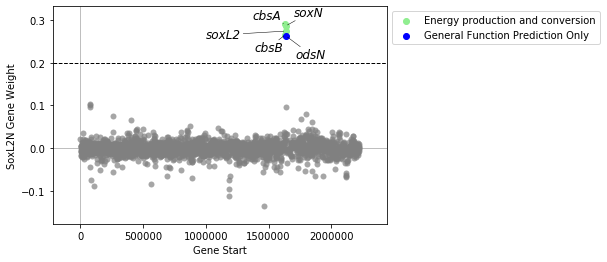

In [6]:
plot_gene_weights(ica_data, 'SoxL2N')

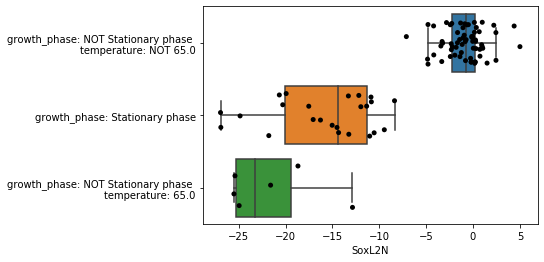

In [7]:
metadata_boxplot(ica_data, 'SoxL2N')

In [8]:
ica_data.view_imodulon('SoxL2N')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS08925,0.289731,cbsA,Saci_1858,Sacid_01828,NaN,1633061,1634449,+,cytochrome b558/566 subunit A,hypothetical protein,Energy production and conversion,A0A0U3GMR5,NC_007181.1,Op1077,NaN
SACI_RS08930,0.266023,cbsB,Saci_1859,Sacid_01829,NaN,1634446,1635378,+,cytochrome b558/566 subunit B,hypothetical protein,Energy production and conversion,A0A0U3FC13,NC_007181.1,Op1077,NaN
SACI_RS08935,0.274232,soxL2,Saci_1860,Sacid_01830,NaN,1635417,1636394,+,Rieske iron-sulfur protein SoxL2,hypothetical protein,Energy production and conversion,A0A0U3GPQ9,NC_007181.1,Op1077,biofilm
SACI_RS08940,0.286235,soxN,Saci_1861,Sacid_01831,petB_1,1636440,1638038,+,cytochrome bc complex cytochrome b subunit SoxN,Cytochrome b6,Energy production and conversion,A0A0U3GR09,NC_007181.1,Op1078,NaN
SACI_RS08945,0.262889,odsN,Saci_1862,Sacid_01832,NaN,1638022,1638354,+,antibiotic biosynthesis monooxygenase,hypothetical protein,General Function Prediction Only,UPI0002B26481,NC_007181.1,Op1078,NaN


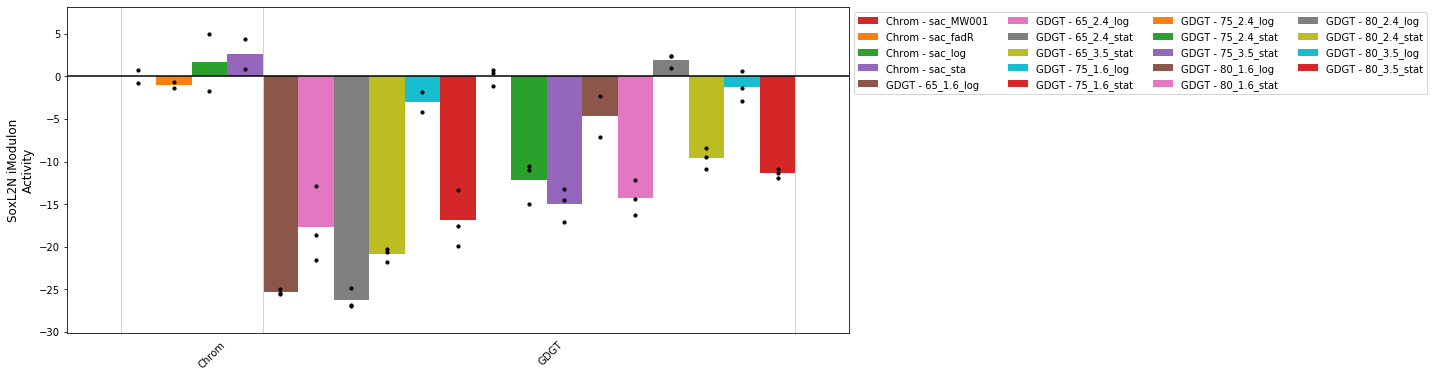

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'SoxL2N', projects=['Chrom', 'GDGT'], highlight=['Chrom', 'GDGT'], ax=ax)

### iModulon 34: Replication/Cell-Division iModulon

Contains:
* segA
* segB
* cdc6-1
* cdvA
* cdvB
* cdvC
* cdvB1
* cdvB2

In [10]:
ica_data.rename_imodulons({34: 'Replication'})

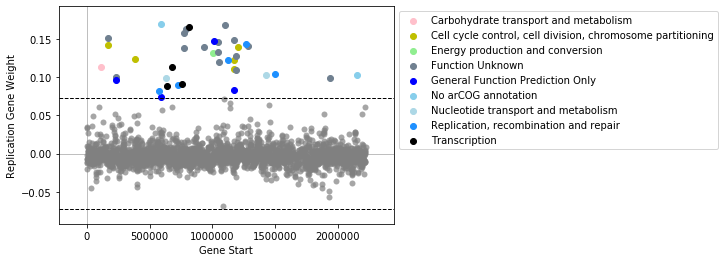

In [11]:
plot_gene_weights(ica_data, 'Replication')

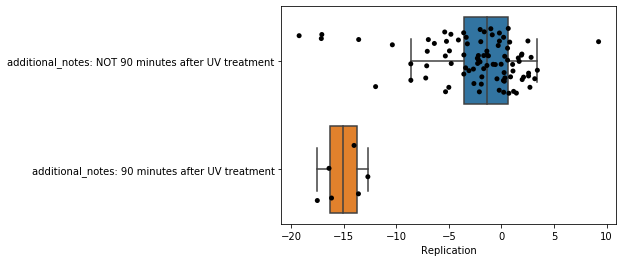

In [12]:
metadata_boxplot(ica_data, 'Replication', n_boxes=2)

In [13]:
ica_data.view_imodulon('Replication')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS00685,0.112974,Saci_0144,Saci_0144,Sacid_00139,NaN,113681,114820,+,MFS transporter,hypothetical protein,Carbohydrate transport and metabolism,A0A0U3FGK7,NC_007181.1,Op80,NaN
SACI_RS00980,0.151865,segB,Saci_0203,Sacid_00197,NaN,165123,165578,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FWP0,NC_007181.1,Op106,NaN
SACI_RS00985,0.142533,segA,Saci_0204,Sacid_00198,"parA, soj",165575,166237,-,ATPase involved in chromosome partitioning Par...,Sporulation initiation inhibitor protein Soj,"Cell cycle control, cell division, chromosome ...",A0A0U2NFX3,NC_007181.1,Op106,NaN
SACI_RS01345,0.099603,Saci_0276,Saci_0276,Sacid_00272,NaN,233183,233515,+,hypothetical protein,hypothetical protein,Function Unknown,UPI0002B28E20,NC_007181.1,Op153,NaN
SACI_RS01350,0.095981,Saci_0277,Saci_0277,Sacid_00273,NaN,233532,234461,+,MBL fold metallo-hydrolase,hypothetical protein,General Function Prediction Only,A0A0U3FFT6,NC_007181.1,Op153,NaN
SACI_RS02185,0.123250,cdvB1,Saci_0451,Sacid_00445,NaN,383513,384157,-,Cell division protein B1,hypothetical protein,"Cell cycle control, cell division, chromosome ...",UPI0000552296,NC_007181.1,Op256,NaN
SACI_RS03440,0.081789,cdc6-1,Saci_0722,Sacid_00700,NaN,578164,579357,-,ORC1-type DNA replication protein 1 (AAA famil...,hypothetical protein,"Replication, recombination and repair",A0A0U2Y835,NC_007181.1,Op383,NaN
SACI_RS03550,0.168987,Saci_0743,Saci_0743,Sacid_00725,NaN,594856,595146,+,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3GVB9,NC_007181.1,Op399,NaN
SACI_RS03555,0.074320,Saci_0744,Saci_0744,Sacid_00726,NaN,595153,596007,+,NAD(P)/FAD-dependent oxidoreductase,hypothetical protein,General Function Prediction Only,A0A0U3HL99,NC_007181.1,Op399,NaN
SACI_RS03775,0.098866,dcd,Saci_0789,Sacid_00769,dcd_1,632052,632570,+,dCTP deaminase,"dCTP deaminase, dUMP-forming",Nucleotide transport and metabolism,A0A0U2Y048,NC_007181.1,Op417,NaN


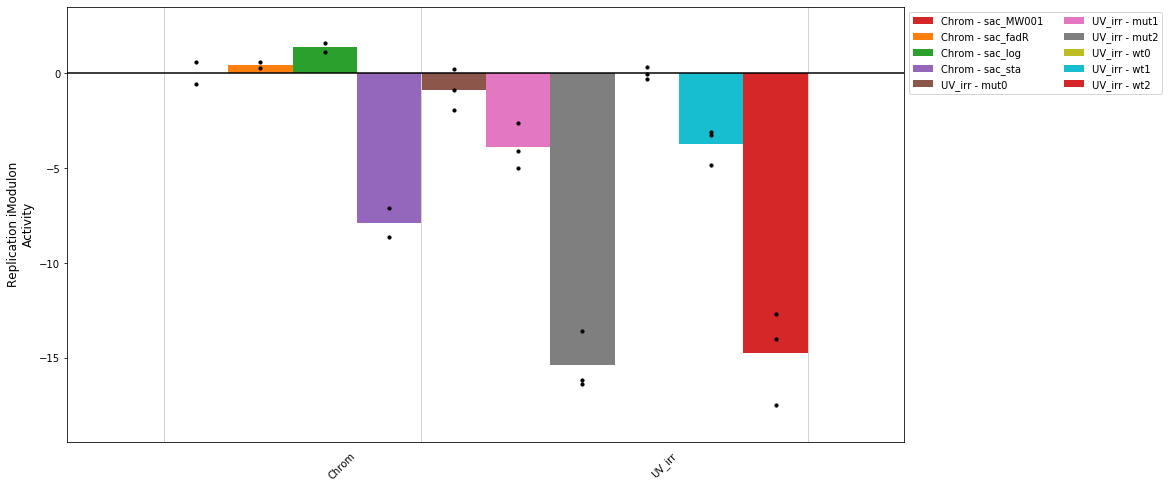

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 'Replication', projects=['Chrom','UV_irr'], highlight=['Chrom','UV_irr'], ax=ax)

### iModulon 35: Translation-related/RpoN iModulon

In [15]:
ica_data.rename_imodulons({35: 'translation-related'})

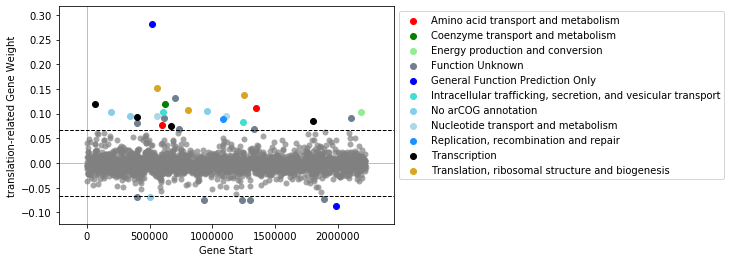

In [16]:
plot_gene_weights(ica_data, 'translation-related')

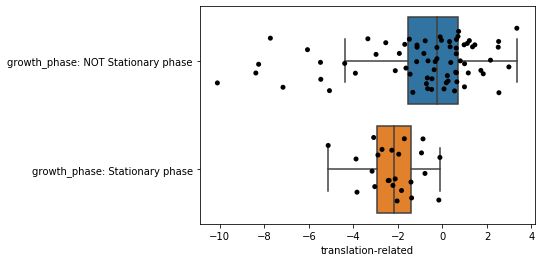

In [17]:
metadata_boxplot(ica_data, 'translation-related', n_boxes=2)

In [18]:
ica_data.view_imodulon('translation-related').sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS03110,0.280566,Saci_0653,Saci_0653,Sacid_00635,NaN,517716,518114,-,tRNA methyltransferase,hypothetical protein,General Function Prediction Only,A0A0U3GNB5,NC_007181.1,Op351,NaN
SACI_RS03315,0.151008,rpl24e,Saci_0697,NaN,NaN,556705,556893,-,50S ribosomal protein L24e,NaN,"Translation, ribosomal structure and biogenesis",A0A0U2N9E7,NC_007181.1,Op371,NaN
SACI_RS07005,0.137219,rpl39e,Saci_1467,Sacid_01434,"rl46, rpl46",1250546,1250707,-,50S ribosomal protein L39e,hypothetical protein,"Translation, ribosomal structure and biogenesis",UPI0000170023,NC_007181.1,Op806,NaN
SACI_RS11610,0.132598,Saci_0873,Saci_0873,Sacid_00851,NaN,700810,700977,-,YHS domain-containing protein,hypothetical protein,Function Unknown,M1ITZ6,NC_007181.1,Op459,NaN
SACI_RS00405,0.120082,rpoN,Saci_0087,Sacid_00083,NaN,66004,66204,+,DNA-directed RNA polymerase subunit N,hypothetical protein,Transcription,A0A0U3H4H5,NC_007181.1,Op45,NaN
SACI_RS03740,0.119686,Saci_0781,Saci_0781,Sacid_00760,NaN,624041,624703,+,uroporphyrinogen-III synthase,hypothetical protein,Coenzyme transport and metabolism,A0A0U3GKS6,NC_007181.1,Op414,NaN
SACI_RS07535,0.110837,hisE,Saci_1580,Sacid_01545,NaN,1350433,1350720,+,phosphoribosyl-ATP diphosphatase,Phosphoribosyl-ATP pyrophosphatase,Amino acid transport and metabolism,A0A0U3H7U1,NC_007181.1,Op869,NaN
SACI_RS04820,0.106832,Saci_1010,Saci_1010,Sacid_00983,NaN,810474,810962,+,DUF1947 domain-containing protein,hypothetical protein,"Translation, ribosomal structure and biogenesis",A0A0U3GS18,NC_007181.1,Op528,NaN
SACI_RS11845,0.105876,SACI_RS11845,NaN,NaN,NaN,955170,955289,+,molybdopterin-dependent oxidoreductase,NaN,No arCOG annotation,UPI0002B27A63,NC_007181.1,Op627,NaN
SACI_RS11320,0.103074,ndhE,Saci_2340,Sacid_02340,NaN,2188490,2188774,-,NADH-quinone oxidoreductase subunit K,"NAD(P)H-quinone oxidoreductase subunit 4L, chl...",Energy production and conversion,A0A0U3GPW4,NC_007181.1,Op1425,NaN


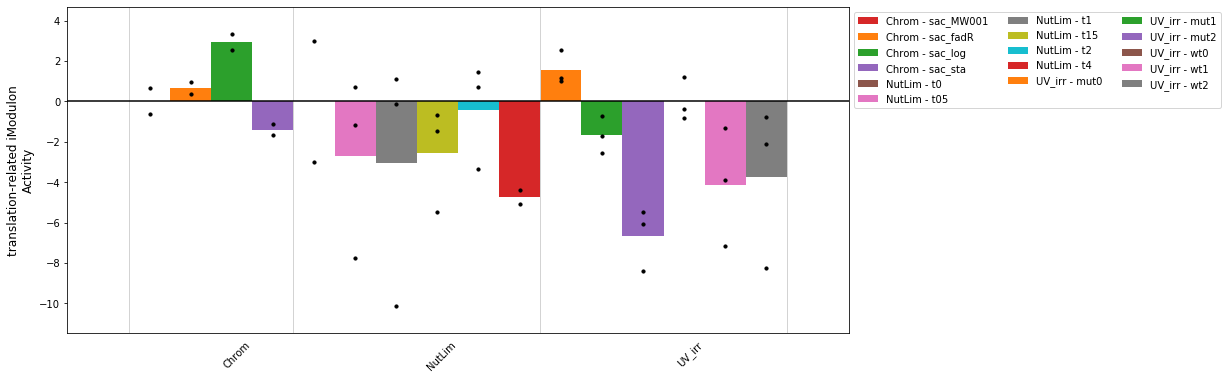

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'translation-related', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 5: Niacin (Vitamin B3) transport iModulon
Consists of:

- Niacin/NAD(H) transporter
- D-xylose:proton symporter
- 2 hypothetical proteins
- Related to iModulon 31 (put. C/N fixation)

In [20]:
ica_data.rename_imodulons({5: 'niacin-transport'})

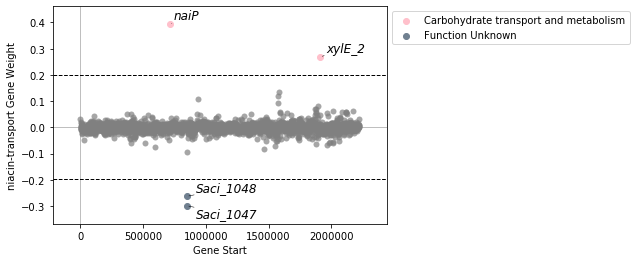

In [21]:
plot_gene_weights(ica_data, 'niacin-transport')

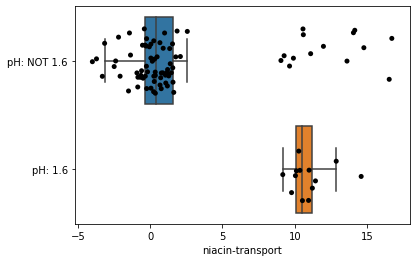

In [22]:
metadata_boxplot(ica_data, 'niacin-transport', n_boxes=2)

In [23]:
ica_data.view_imodulon('niacin-transport')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS04230,0.392167,naiP,Saci_0886,Sacid_00863,NaN,712521,714002,-,MFS transporter,Putative niacin/nicotinamide transporter NaiP,Carbohydrate transport and metabolism,A0A0U3HAF2,NC_007181.1,Op468,NaN
SACI_RS05000,-0.298456,Saci_1047,Saci_1047,Sacid_01021,NaN,848080,848499,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3H1U4,NC_007181.1,Op551,NaN
SACI_RS05005,-0.262939,Saci_1048,Saci_1048,Sacid_01022,NaN,848599,848853,+,DUF504 domain-containing protein,hypothetical protein,Function Unknown,A0A0U3H296,NC_007181.1,Op552,NaN
SACI_RS10120,0.268527,xylE_2,Saci_2095,Sacid_02091,NaN,1912263,1913636,-,MFS transporter,D-xylose-proton symporter,Carbohydrate transport and metabolism,A0A0U3GM32,NC_007181.1,Op1248,NaN


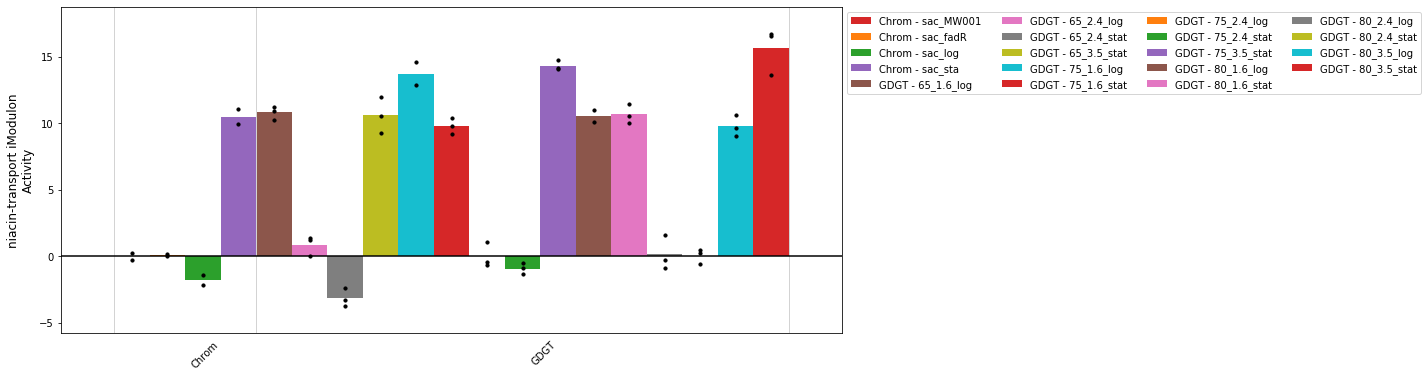

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'niacin-transport', projects=['Chrom', 'GDGT'], highlight=['Chrom', 'GDGT'], ax=ax)

### iModulon 41: Thiamin (Vit B1) iModulon (Potentially Heavy-Metal related)

In [25]:
ica_data.rename_imodulons({41: 'Thiamin'})

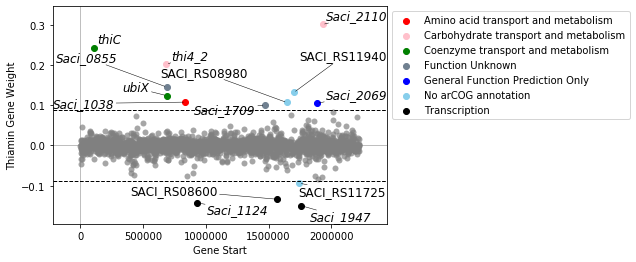

In [26]:
plot_gene_weights(ica_data, 'Thiamin')

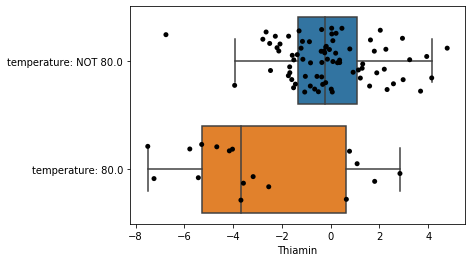

In [27]:
metadata_boxplot(ica_data, 'Thiamin', n_boxes=2)

In [28]:
ica_data.view_imodulon('Thiamin').sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS10200,0.300793,Saci_2110,Saci_2110,Sacid_02107,NaN,1931025,1932332,-,MFS transporter,hypothetical protein,Carbohydrate transport and metabolism,A0A0U3FXT5,NC_007181.1,Op1257,NaN
SACI_RS00650,0.242554,thiC,Saci_0137,Sacid_00132,bzaF,107432,108718,+,phosphomethylpyrimidine synthase ThiC (thiamin),5-hydroxybenzimidazole synthase,Coenzyme transport and metabolism,A0A0U2Y1Q4,NC_007181.1,Op74,NaN
SACI_RS04090,0.201410,thi4_2,Saci_0854,Sacid_00833,thi4,685342,686139,-,thiazole biosynthesis protein,Thiamine thiazole synthase,Carbohydrate transport and metabolism,A0A0U2XZZ7,NC_007181.1,Op446,NaN
SACI_RS11600,0.145373,Saci_0855,Saci_0855,NaN,NaN,686222,686431,+,TRASH domain-containing protein,NaN,Function Unknown,UPI00005523E6,NC_007181.1,Op447,NaN
SACI_RS11940,0.131866,SACI_RS11940,NaN,NaN,NaN,1701777,1702049,+,hypothetical protein,NaN,No arCOG annotation,UPI0002B260AD,NC_007181.1,Op1110,NaN
SACI_RS04095,0.123935,ubiX,Saci_0856,Sacid_00834,NaN,686362,687024,+,UbiX family flavin prenyltransferase,Flavin prenyltransferase UbiX,Coenzyme transport and metabolism,A0A0U2WZN2,NC_007181.1,Op447,NaN
SACI_RS04960,0.107777,Saci_1038,Saci_1038,Sacid_01012,NaN,836997,839600,-,ABC transporter substrate-binding protein,hypothetical protein,Amino acid transport and metabolism,A0A0U2NE45,NC_007181.1,Op546,NaN
SACI_RS08980,0.106838,SACI_RS08980,NaN,NaN,NaN,1644920,1645132,-,hypothetical protein,NaN,No arCOG annotation,A0A0U3H528,NC_007181.1,Op1085,NaN
SACI_RS10005,0.104651,Saci_2069,Saci_2069,Sacid_02064,NaN,1887074,1887406,+,metal-sulfur cluster assembly factor,hypothetical protein,General Function Prediction Only,A0A0U3FYQ8,NC_007181.1,Op1229,NaN
SACI_RS11700,0.100666,Saci_1709,Saci_1709,NaN,NaN,1468477,1468635,-,TRASH domain-containing protein,NaN,Function Unknown,UPI00005526DC,NC_007181.1,Op951,NaN


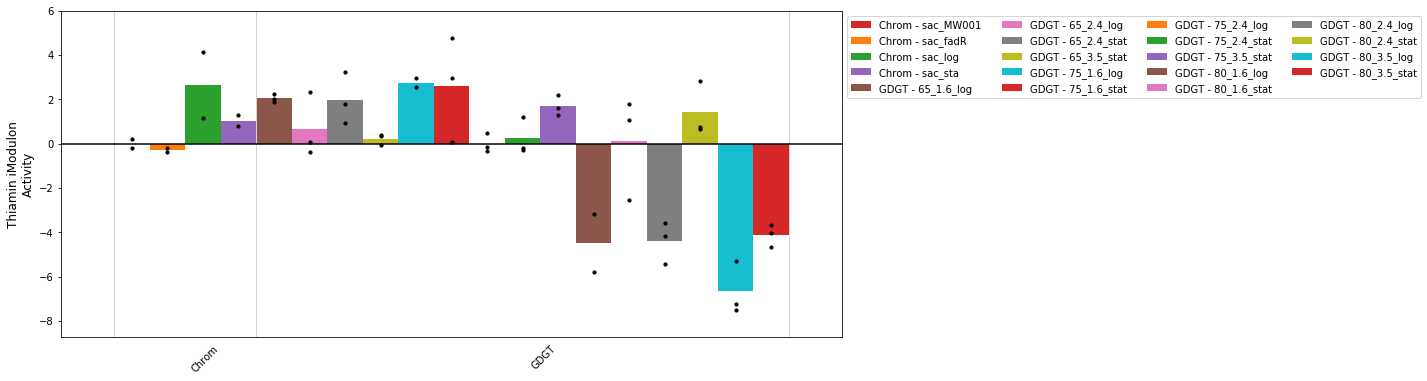

In [29]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Thiamin', projects=['Chrom', 'GDGT'], highlight=['Chrom', 'GDGT'], ax=ax)

### iModulon 22: Uncharacterized iModulon 1

- 3 integrases and 1 PIN domain endonuclease
- Potentially from a virus?
- temperature dependence furthers virus possibility

In [30]:
ica_data.rename_imodulons({22: 'unchar-1'})

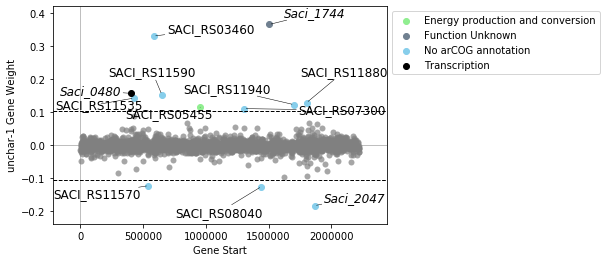

In [31]:
plot_gene_weights(ica_data, 'unchar-1')

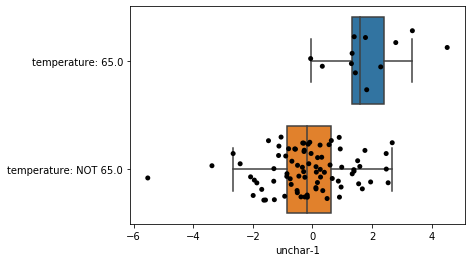

In [32]:
metadata_boxplot(ica_data, 'unchar-1', n_boxes=2)

In [33]:
ica_data.view_imodulon('unchar-1')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS02320,0.157630,Saci_0480,Saci_0480,Sacid_00473,NaN,402468,402758,+,hypothetical protein,hypothetical protein,Transcription,A0A0U2NCG0,NC_007181.1,Op272,NaN
SACI_RS11535,0.143340,SACI_RS11535,NaN,Sacid_00511,NaN,426819,427622,-,integrase,hypothetical protein,No arCOG annotation,UPI0002B29D24,NC_007181.1,Op298,NaN
SACI_RS11570,-0.121978,SACI_RS11570,NaN,NaN,NaN,542365,542577,+,putative integrase,NaN,No arCOG annotation,UPI000AE9D732,NC_007181.1,Op365,NaN
SACI_RS03460,0.331180,SACI_RS03460,NaN,Sacid_00705,NaN,584094,584273,+,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3FV95,NC_007181.1,Op387,NaN
SACI_RS11590,0.153685,SACI_RS11590,NaN,NaN,NaN,648575,648803,+,hypothetical protein,NaN,No arCOG annotation,NaN,NC_007181.1,Op429,NaN
SACI_RS05455,0.115709,SACI_RS05455,NaN,Sacid_01120,NaN,954960,955145,+,hypothetical protein,hypothetical protein,Energy production and conversion,A0A0U3H132,NC_007181.1,Op627,NaN
SACI_RS07300,0.111402,SACI_RS07300,NaN,Sacid_01497,NaN,1305203,1306027,-,integrase,hypothetical protein,No arCOG annotation,UPI000B5A97B4,NC_007181.1,Op845,NaN
SACI_RS08040,-0.124633,SACI_RS08040,NaN,Sacid_01648,NaN,1443061,1443315,-,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3GYK6,NC_007181.1,Op935,NaN
SACI_RS08335,0.366300,Saci_1744,Saci_1744,Sacid_01708,NaN,1504455,1504646,+,DUF3311 domain-containing protein,hypothetical protein,Function Unknown,A0A0U3H881,NC_007181.1,Op982,NaN
SACI_RS11940,0.123354,SACI_RS11940,NaN,NaN,NaN,1701777,1702049,+,hypothetical protein,NaN,No arCOG annotation,UPI0002B260AD,NC_007181.1,Op1110,NaN


### iModulon 33: Uncharacterized iModulon 2  (also named "Discovered signal with Absent Regulatory Components" aka DARC)

In [34]:
ica_data.rename_imodulons({33: 'DARC'})

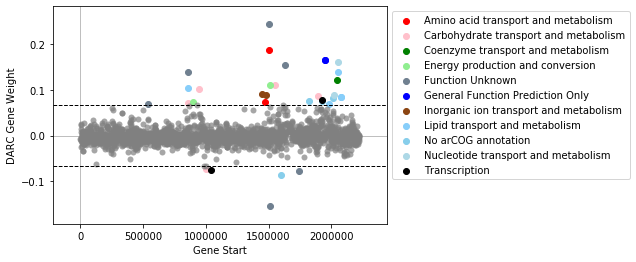

In [35]:
plot_gene_weights(ica_data, 'DARC')

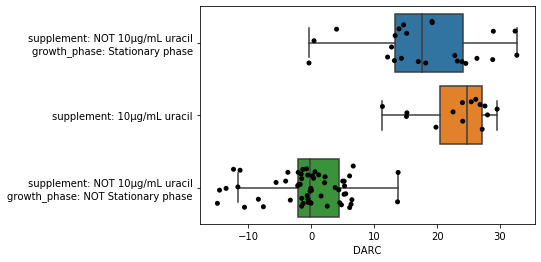

In [36]:
metadata_boxplot(ica_data, 'DARC', n_boxes=3)

In [37]:
ica_data.view_imodulon('DARC')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS03235,0.069043,Saci_0680,Saci_0680,Sacid_00661,NaN,540470,541363,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3GK13,NC_007181.1,Op363,NaN
SACI_RS05025,0.139720,Saci_1052,Saci_1052,Sacid_01026,NaN,853736,854056,+,GYD domain-containing protein,Glutamine synthetase and cystathionine beta-ly...,Function Unknown,A0A0U2VU45,NC_007181.1,Op555,NaN
SACI_RS05035,0.102884,Saci_1054,Saci_1054,Sacid_01028,NaN,855397,857076,+,4-Hydroxybutyrate-CoA synthetase (E10 alt),Long-chain-fatty-acid--CoA ligase,Lipid transport and metabolism,UPI0002B29646,NC_007181.1,Op557,NaN
SACI_RS05050,0.070690,glpK_3,Saci_1058,Sacid_01033,NaN,860143,861657,-,FGGY-family carbohydrate kinase,Glycerol kinase,Carbohydrate transport and metabolism,A0A0U3H185,NC_007181.1,Op561,NaN
SACI_RS05235,0.072807,gbsA,Saci_1099,Sacid_01075,NaN,897628,899109,+,aldehyde dehydrogenase,Betaine aldehyde dehydrogenase,Energy production and conversion,A0A0U3H157,NC_007181.1,Op592,NaN
SACI_RS05415,0.102230,ydjE_1,Saci_1136,Sacid_01111,NaN,944847,946262,+,MFS transporter,Inner membrane metabolite transport protein YdjE,Carbohydrate transport and metabolism,A0A0U3H243,NC_007181.1,Op620,NaN
SACI_RS05635,-0.073493,stp,Saci_1182,Sacid_01159,NaN,998087,999520,-,"MFS permease, MFS transporter",Multidrug resistance protein Stp,Carbohydrate transport and metabolism,A0A0U3H154,NC_007181.1,Op652,BarR
SACI_RS05830,-0.075014,abfR2,Saci_1223,Sacid_01200,NaN,1041456,1041827,+,Lrs14 family biofilm regulator AbfR2,hypothetical protein,Transcription,A0A0U3FE21,NC_007181.1,Op678,biofilm
SACI_RS08080,0.091552,Saci_1692,Saci_1692,Sacid_01656,NaN,1450416,1450697,+,cation transporter,hypothetical protein,Inorganic ion transport and metabolism,A0A0U3H5I8,NC_007181.1,Op940,NaN
SACI_RS08185,0.072719,thpS,Saci_1714,Sacid_01677,NaN,1473212,1474234,-,thermopsin,hypothetical protein,Amino acid transport and metabolism,A0A0U3H5H2,NC_007181.1,Op956,NaN


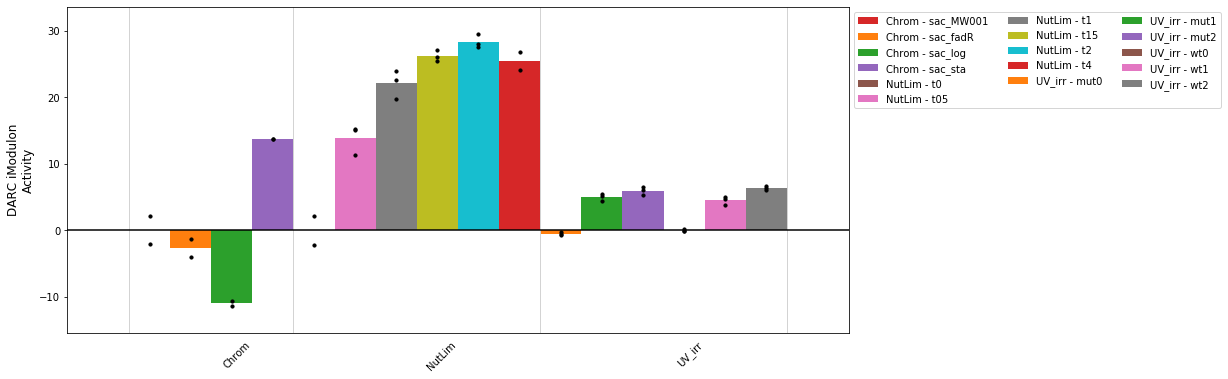

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'DARC', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 32: UV Stress Related iModulon

In [39]:
ica_data.rename_imodulons({32: 'UV-related'})

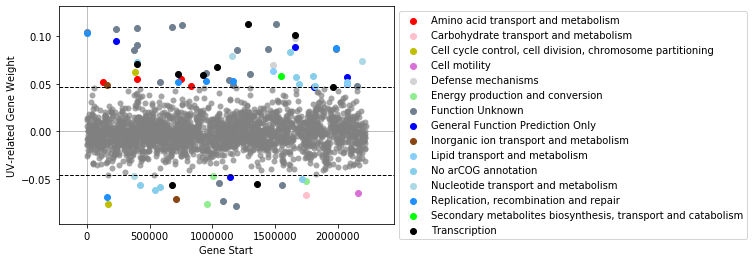

In [40]:
plot_gene_weights(ica_data, 'UV-related')

In [41]:
# Uncomment below to see genes enriched in this iModulon

#ica_data.view_imodulon('UV-related')[0:40]
#ica_data.view_imodulon('UV-related')[40:]

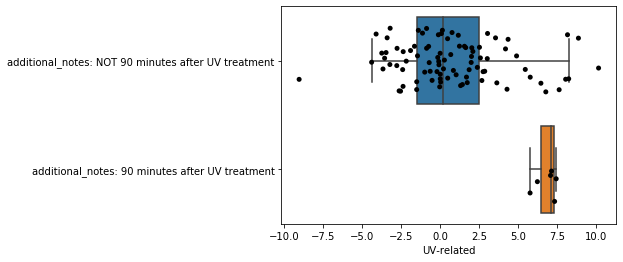

In [42]:
metadata_boxplot(ica_data, 'UV-related', n_boxes=2)

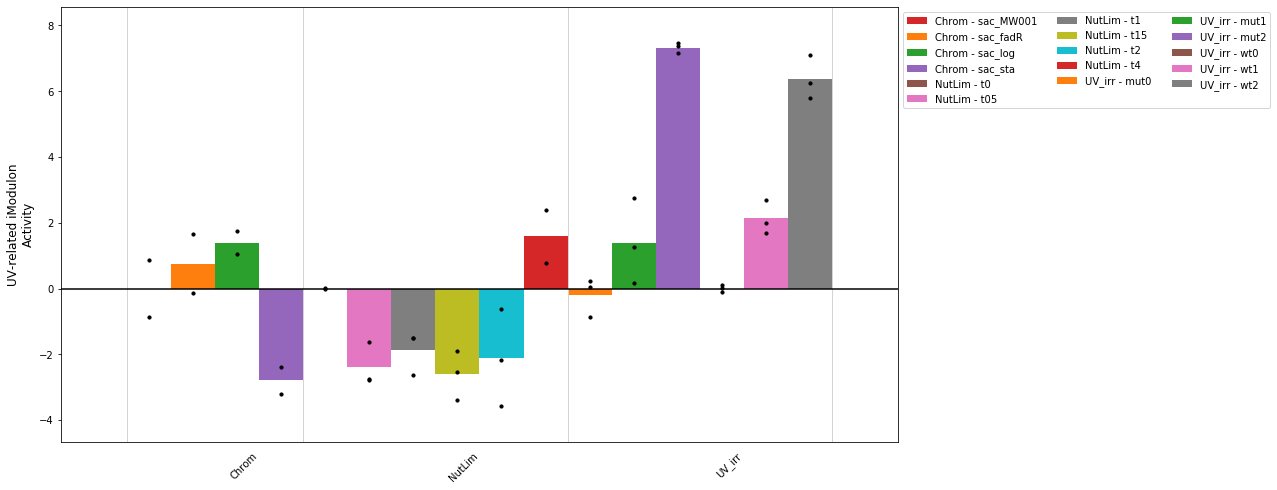

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 'UV-related', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 38: Ammonium Uptake iModulon [E coli Ortholog: NtrC+RpoN]
### Probable Nitrogen Metabolism Involvement

In [44]:
ica_data.rename_imodulons({38: 'Ammonium-Uptake'})

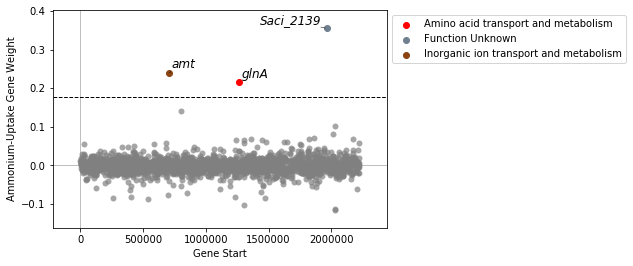

In [45]:
plot_gene_weights(ica_data, 'Ammonium-Uptake')

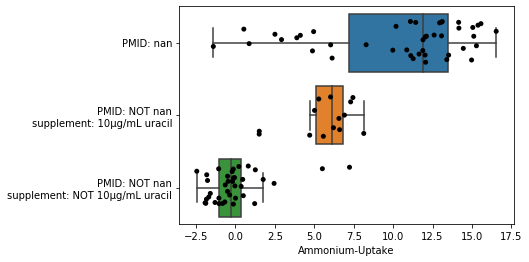

In [46]:
metadata_boxplot(ica_data, 'Ammonium-Uptake')

In [47]:
ica_data.view_imodulon('Ammonium-Uptake')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS04215,0.240628,amt,Saci_0883,Sacid_00860,NaN,708849,710294,+,"Ammonia permease, ammonium transporter",Ammonia channel,Inorganic ion transport and metabolism,UPI0002B27354,NC_007181.1,Op465,XylR
SACI_RS07075,0.215236,glnA,Saci_1483,Sacid_01450,glnA_1,1261179,1262600,-,type I glutamate--ammonia ligase,Glutamine synthetase,Amino acid transport and metabolism,A0A0U2WW46,NC_007181.1,Op816,LrpC
SACI_RS10345,0.354988,Saci_2139,Saci_2139,Sacid_02137,NaN,1966994,1967353,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FQV9,NC_007181.1,Op1282,XylR


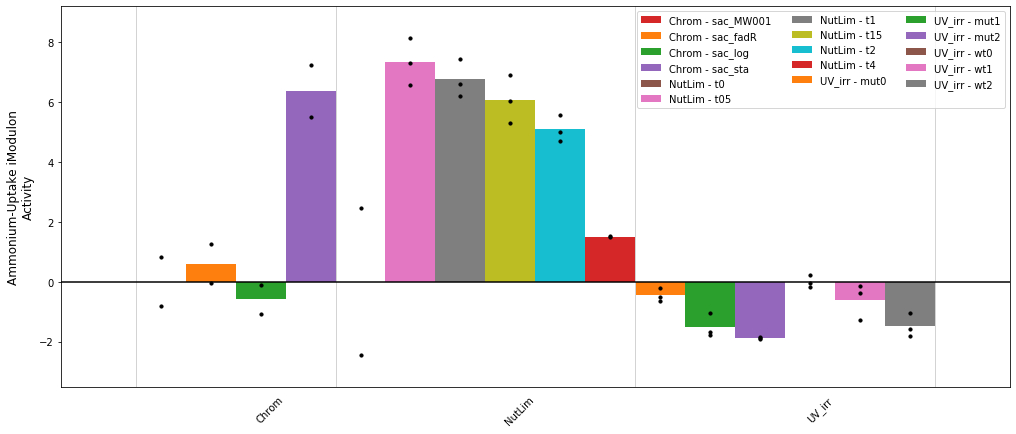

In [48]:
fig, ax = plt.subplots(figsize=(17, 7))

plot_activities(ica_data, 'Ammonium-Uptake', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

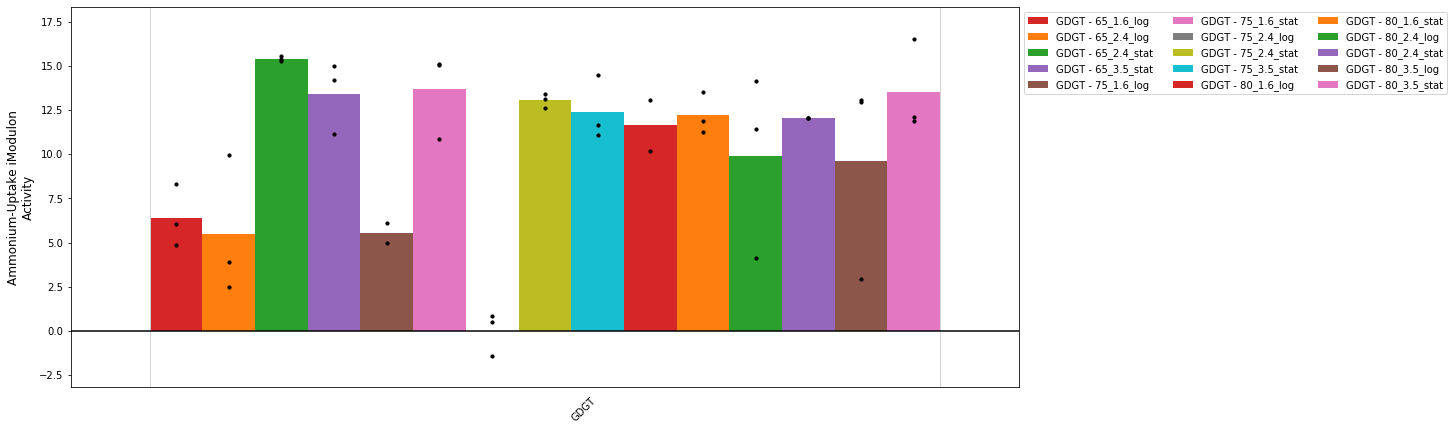

In [49]:
# Very messy activities with GDGT
fig, ax = plt.subplots(figsize=(17, 7))

plot_activities(ica_data, 'Ammonium-Uptake', projects='GDGT', highlight='GDGT', ax=ax)

### iModulon 14: Phenylacetate Degradation iModulon

- https://febs.onlinelibrary.wiley.com/doi/epdf/10.1111/febs.14105

- paaX (Saci_1775) is repressing TF for this iModulon

In [50]:
ica_data.rename_imodulons({14: 'Phenylacetate'})

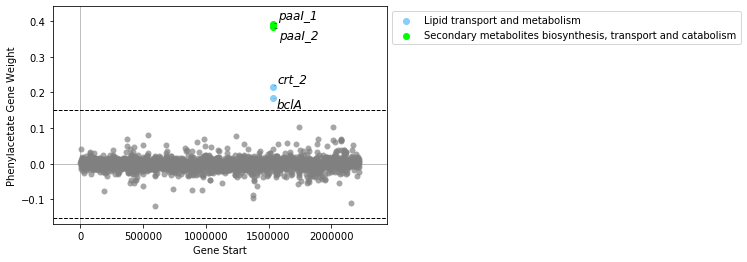

In [51]:
plot_gene_weights(ica_data, 'Phenylacetate')

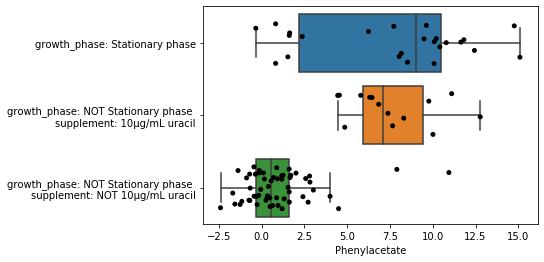

In [52]:
metadata_boxplot(ica_data, 'Phenylacetate')

In [53]:
ica_data.view_imodulon('Phenylacetate')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS08465,0.390392,paaI_1,Saci_1770,Sacid_01736,paaI,1531395,1532090,-,phenylacetate-CoA oxygenase subunit PaaI,hypothetical protein,"Secondary metabolites biosynthesis, transport ...",A0A0U3H790,NC_007181.1,Op1002,NaN
SACI_RS08470,0.382446,paaI_2,Saci_1771,Sacid_01737,"paaI, boxB",1532100,1532870,-,phenylacetate-CoA oxygenase subunit PaaI,Benzoyl-CoA oxygenase component B,"Secondary metabolites biosynthesis, transport ...",A0A0U3FSM1,NC_007181.1,Op1002,NaN
SACI_RS08475,0.215781,crt_2,Saci_1772,Sacid_01738,NaN,1533033,1533836,+,enoyl-CoA hydratase/isomerase family protein,Short-chain-enoyl-CoA hydratase,Lipid transport and metabolism,A0A0U3GMZ0,NC_007181.1,Op1003,NaN
SACI_RS08485,0.184597,bclA,Saci_1774,Sacid_01740,NaN,1535691,1537271,+,benzoate-CoA ligase family protein,Benzoate--CoA ligase,Lipid transport and metabolism,A0A0U3HIU5,NC_007181.1,Op1005,NaN


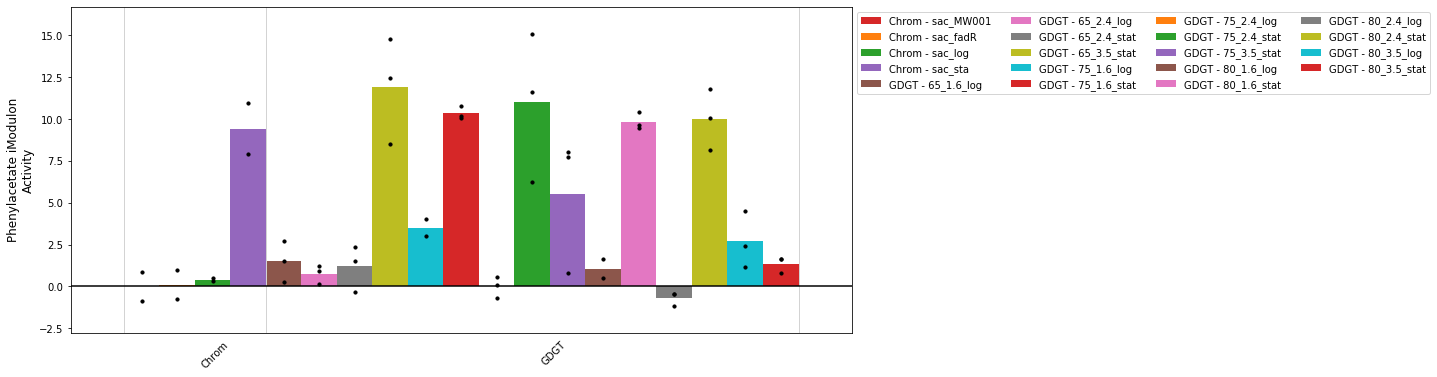

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Phenylacetate', projects=['Chrom','GDGT'], highlight=['Chrom', 'GDGT'], ax=ax)

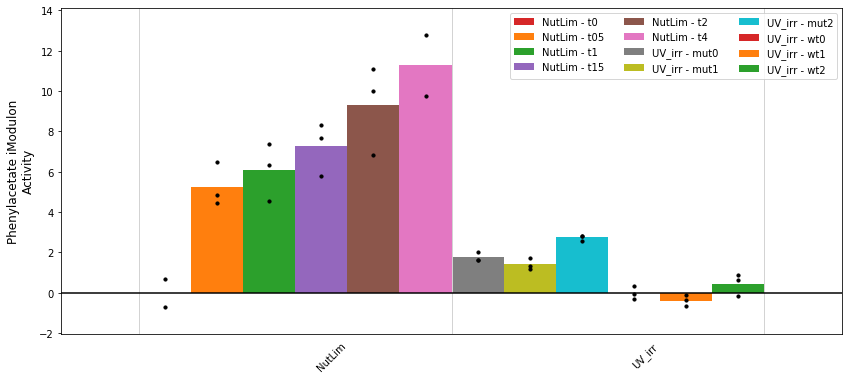

In [55]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Phenylacetate', projects=['NutLim', 'UV_irr'],
                highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 8: Iron-Sulfur-Lipoylation-Associated iModulon

Many iron-sulfur related genes

Many lipoylation/acyl-lipid-carrier proteins

In [56]:
ica_data.rename_imodulons({8: 'Fe-S-lipoylation'})

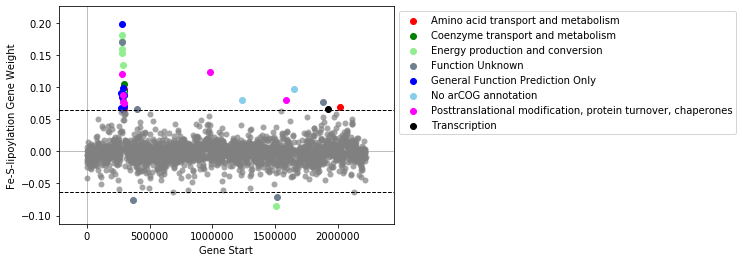

In [57]:
plot_gene_weights(ica_data, 'Fe-S-lipoylation')

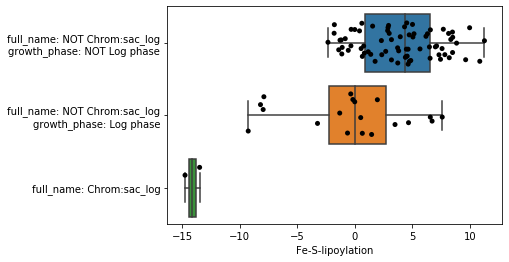

In [58]:
metadata_boxplot(ica_data, 'Fe-S-lipoylation', n_boxes=3)

In [59]:
ica_data.view_imodulon('Fe-S-lipoylation')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01565,0.068132,fdhF,Saci_0320,Sacid_00316,NaN,272254,275184,-,formate dehydrogenase subunit alpha,Putative formate dehydrogenase,General Function Prediction Only,A0A0U2Y905,NC_007181.1,Op183,NaN
SACI_RS01570,0.090674,Saci_0321,Saci_0321,Sacid_00317,NaN,275396,276538,-,2'-5' RNA ligase family protein,hypothetical protein,General Function Prediction Only,A0A0U3H3W5,NC_007181.1,Op184,NaN
SACI_RS01585,0.197796,Saci_0324,Saci_0324,Sacid_00320,NaN,277460,278311,-,sulfite exporter TauE/SafE family protein,putative membrane transporter protein,General Function Prediction Only,A0A0U2VW32,NC_007181.1,Op186,NaN
SACI_RS01590,0.153582,hdrB2,Saci_0325,Sacid_00321,sdhE_1,278371,279282,-,CoB--CoM heterodisulfide reductase iron-sulfur...,8-methylmenaquinol:fumarate reductase membrane...,Energy production and conversion,A0A0U3FPF4,NC_007181.1,Op187,NaN
SACI_RS01595,0.158831,hdrC2,Saci_0326,Sacid_00322,NaN,279279,279971,-,"4Fe-4S dicluster domain-containing protein, he...",hypothetical protein,Energy production and conversion,A0A0U2WT74,NC_007181.1,Op187,NaN
SACI_RS01600,0.170436,Saci_0327,Saci_0327,Sacid_00323,NaN,279958,280641,-,"Heterodisulfide reductase, subunit A, polyferr...",hypothetical protein,Function Unknown,A0A0U2Y162,NC_007181.1,Op187,XylR
SACI_RS01605,0.180646,hdrA,Saci_0328,Sacid_00324,thi4_1,280685,281782,-,CoB--CoM heterodisulfide reductase iron-sulfur...,Thiamine thiazole synthase,Energy production and conversion,A0A0U3GTK9,NC_007181.1,Op188,NaN
SACI_RS01610,0.172489,hdrB1,Saci_0329,Sacid_00325,NaN,281837,283147,-,heterodisulfide reductase subunit B,hypothetical protein,Energy production and conversion,A0A0U3GUQ8,NC_007181.1,Op189,NaN
SACI_RS01615,0.119824,Saci_0330,Saci_0330,Sacid_00326,NaN,283670,283903,+,sulfurtransferase TusA family protein,hypothetical protein,"Posttranslational modification, protein turnov...",A0A0U3FNF5,NC_007181.1,Op190,NaN
SACI_RS01620,0.085121,Saci_0331,Saci_0331,Sacid_00327,SQO,283916,285073,+,sulphide: quinone oxidoreductase NAD(P)/FAD-de...,hypothetical protein,General Function Prediction Only,A0A0U3H3H3,NC_007181.1,Op190,biofilm


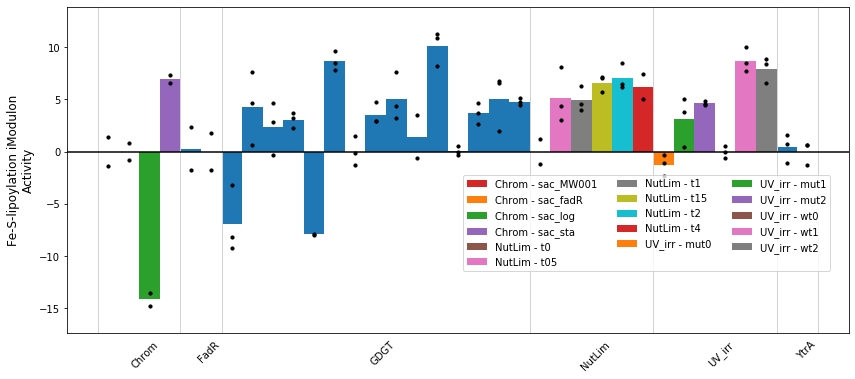

In [60]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Fe-S-lipoylation', highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.5, 0.5)})

### iModulon 3: Fatty-Acid Related iModulon

* Contains Saci_2137, a known gene regulated by Saci_2136 (barR)
* Potentially regulated by BarR or BarR-like TF

In [61]:
ica_data.rename_imodulons({3: 'fatty-acid-related'})

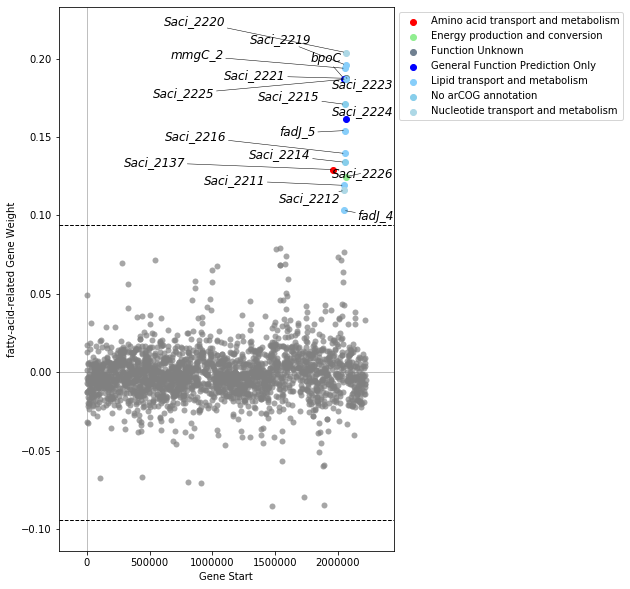

In [62]:
fig, ax = plt.subplots(figsize=(6, 10))

plot_gene_weights(ica_data, 'fatty-acid-related', ax=ax)

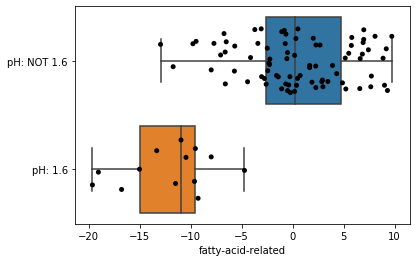

In [63]:
metadata_boxplot(ica_data, 'fatty-acid-related', n_boxes=2)

In [64]:
ica_data.view_imodulon('fatty-acid-related')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS10335,0.129288,Saci_2137,Saci_2137,Sacid_02135,spuC,1964516,1965850,+,beta-alanine aminotransferase,Putrescine--pyruvate aminotransferase,Amino acid transport and metabolism,A0A0U3HCW1,NC_007181.1,Op1280,"BarR,hypotonic-K,hypotonic-all"
SACI_RS10675,0.103259,fadJ_4,Saci_2208,Sacid_02209,NaN,2046825,2048798,-,3-hydroxyacyl-CoA dehydrogenase/enoyl-CoA hydr...,Fatty acid oxidation complex subunit alpha,Lipid transport and metabolism,A0A0U3FHD7,NC_007181.1,Op1337,NaN
SACI_RS10690,0.119224,Saci_2211,Saci_2211,Sacid_02212,NaN,2050681,2052348,-,long-chain-fatty-acid--CoA ligase,Long-chain-fatty-acid--CoA ligase,Lipid transport and metabolism,A0A0U3GLS7,NC_007181.1,Op1339,NaN
SACI_RS10695,0.116022,Saci_2212,Saci_2212,Sacid_02213,NaN,2052558,2053550,+,R2-like ligand-binding oxidase,hypothetical protein,Nucleotide transport and metabolism,A0A0U3GN22,NC_007181.1,Op1340,NaN
SACI_RS10700,0.186997,bpoC,Saci_2213,Sacid_02214,NaN,2053621,2054565,-,alpha/beta hydrolase,Putative non-heme bromoperoxidase BpoC,General Function Prediction Only,F2Z668,NC_007181.1,Op1341,NaN
SACI_RS10705,0.133943,Saci_2214,Saci_2214,Sacid_02215,NaN,2054663,2056171,-,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3GXE1,NC_007181.1,Op1342,NaN
SACI_RS10710,0.170888,Saci_2215,Saci_2215,Sacid_02216,NaN,2056355,2058994,-,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3GHV8,NC_007181.1,Op1343,NaN
SACI_RS10715,0.139543,Saci_2216,Saci_2216,Sacid_02217,NaN,2059230,2059847,-,hypothetical protein,hypothetical protein,Lipid transport and metabolism,A0A0U2VXF7,NC_007181.1,Op1344,NaN
SACI_RS10720,0.193837,mmgC_2,Saci_2217,Sacid_02219,NaN,2059997,2061196,+,acyl-CoA dehydrogenase family protein,Acyl-CoA dehydrogenase,Lipid transport and metabolism,A0A0U3FQM0,NC_007181.1,Op1345,NaN
SACI_RS10725,0.154157,fadJ_5,Saci_2218,Sacid_02220,NaN,2061332,2063251,+,3-hydroxyacyl-CoA dehydrogenase/enoyl-CoA hydr...,Fatty acid oxidation complex subunit alpha,Lipid transport and metabolism,A0A0U3FYV7,NC_007181.1,Op1346,NaN


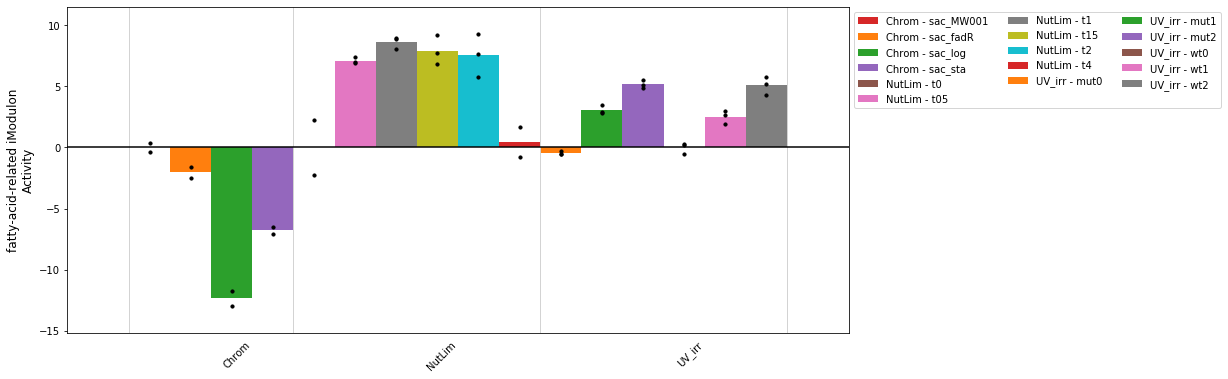

In [65]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'fatty-acid-related', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

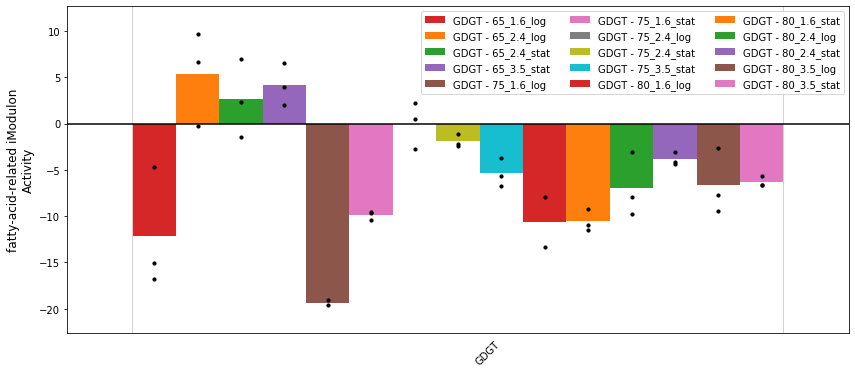

In [66]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'fatty-acid-related', projects='GDGT', highlight='GDGT', ax=ax)

### iModulon 0: pseudogene iModulon

* According to Biocyc SACI_RS05165 is a frame-shifted pseudogene

In [67]:
ica_data.rename_imodulons({0: 'pseudogene'})

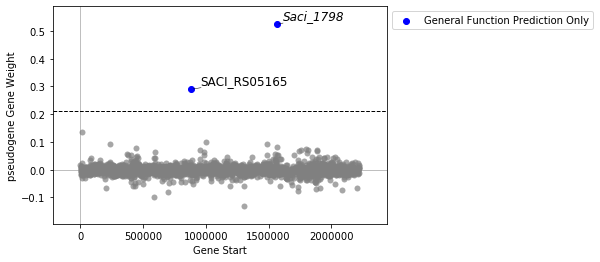

In [68]:
plot_gene_weights(ica_data, 'pseudogene')

In [69]:
ica_data.view_imodulon('pseudogene')

# SACI_RS08610 is a framshifted pseudogene (biocyc)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS05165,0.290069,SACI_RS05165,NaN,"Sacid_01058, Sacid_01059",NaN,883177,883904,-,hypothetical protein,hypothetical protein,General Function Prediction Only,NaN,NC_007181.1,Op578,NaN
SACI_RS08610,0.523578,Saci_1798,Saci_1798,Sacid_01767,NaN,1564898,1565779,+,hypothetical protein,hypothetical protein,General Function Prediction Only,A0A0U3GKI8,NC_007181.1,Op1024,NaN


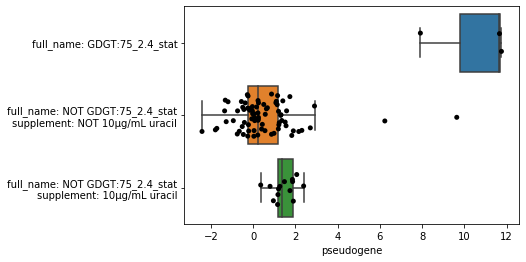

In [70]:
# Plots below show something odd going on with 75 C, 2.4 pH, stationary phase condition
# next big difference is with NutLim project
metadata_boxplot(ica_data, 'pseudogene')

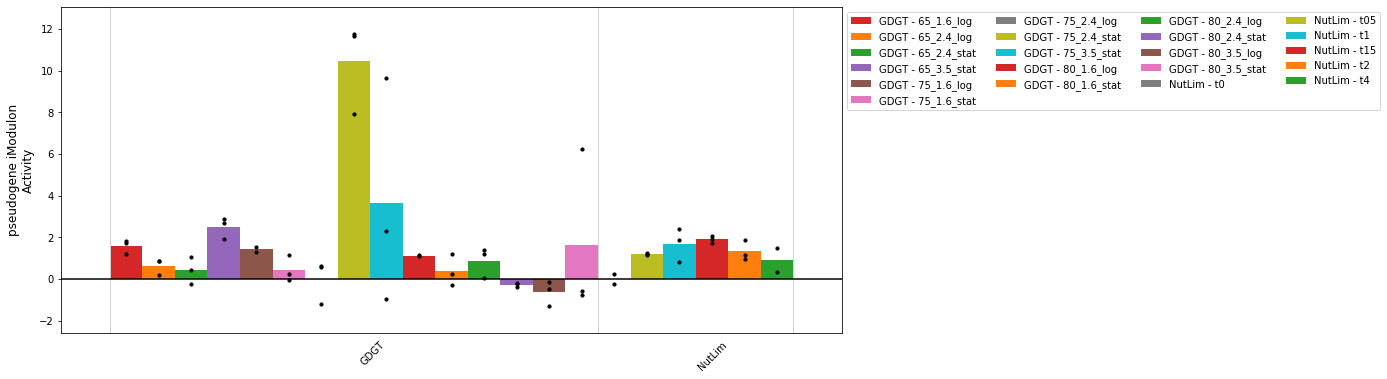

In [71]:
# 75 C, 3.5 pH, stationary phase & 80 C, 3.5 pH, stationary phase also show some odd activity
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'pseudogene', projects=['GDGT', 'NutLim'], highlight=['GDGT', 'NutLim'], ax=ax)

### iModulon 1: heat-stress iModulon (different from heat-shock)

In [72]:
ica_data.rename_imodulons({1: 'heat-stress'})

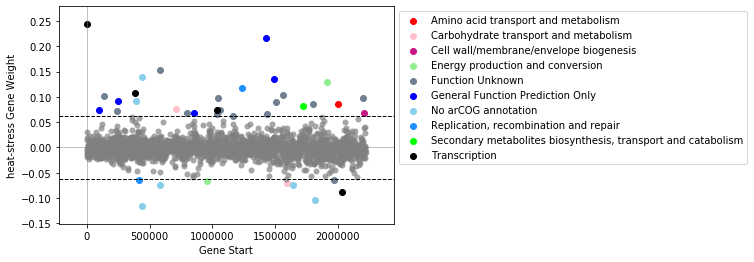

In [73]:
plot_gene_weights(ica_data, 'heat-stress')

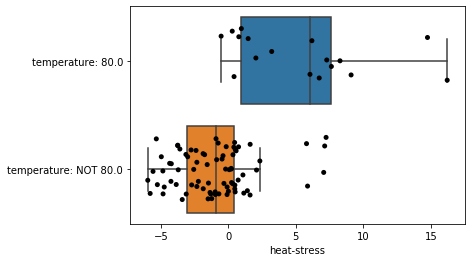

In [74]:
metadata_boxplot(ica_data, 'heat-stress', n_boxes=2)

In [75]:
ica_data.view_imodulon('heat-stress')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS00030,0.243027,Saci_0006,Saci_0006,Sacid_00006,NaN,3801,4052,-,winged helix-turn-helix transcriptional regulator,hypothetical protein,Transcription,A0A0U3F8V4,NC_007181.1,Op1,NaN
SACI_RS00605,0.074336,Saci_0128,Saci_0128,Sacid_00123,NaN,99663,100643,+,stage II sporulation protein M,hypothetical protein,General Function Prediction Only,A0A0U3GMB5,NC_007181.1,Op67,NaN
SACI_RS00795,0.101912,Saci_0167,Saci_0167,Sacid_00161,NaN,136962,137603,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3HB35,NC_007181.1,Op95,NaN
SACI_RS01395,0.072524,Saci_0286,Saci_0286,Sacid_00282,NaN,241651,242223,-,DedA family protein,hypothetical protein,Function Unknown,A0A0U2Y936,NC_007181.1,Op157,NaN
SACI_RS01445,0.092265,moaA_1,Saci_0296,Sacid_00292,NaN,251845,252864,-,PTO1314 family radical SAM protein,"GTP 3',8-cyclase",General Function Prediction Only,A0A0U3H336,NC_007181.1,Op165,NaN
SACI_RS02175,0.108268,Saci_0449,Saci_0449,Sacid_00443,NaN,381830,382318,+,helix-turn-helix domain-containing protein,hypothetical protein,Transcription,A0A0U3HAC8,NC_007181.1,Op254,NaN
SACI_RS02250,0.091161,Saci_0464,Saci_0464,Sacid_00458,NaN,392594,393088,-,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U2X0I3,NC_007181.1,Op264,NaN
SACI_RS02420,-0.064121,Saci_0503,Saci_0503,Sacid_00497,NaN,417681,417860,+,hypothetical protein,hypothetical protein,"Replication, recombination and repair",A0A0U3FN09,NC_007181.1,Op288,NaN
SACI_RS02570,0.138449,Saci_0538,Saci_0538,Sacid_00528,NaN,440555,440959,-,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3F7L4,NC_007181.1,Op308,NaN
SACI_RS11800,-0.114979,SACI_RS11800,NaN,NaN,NaN,442246,442317,-,hypothetical protein,NaN,No arCOG annotation,NaN,NC_007181.1,Op310,NaN


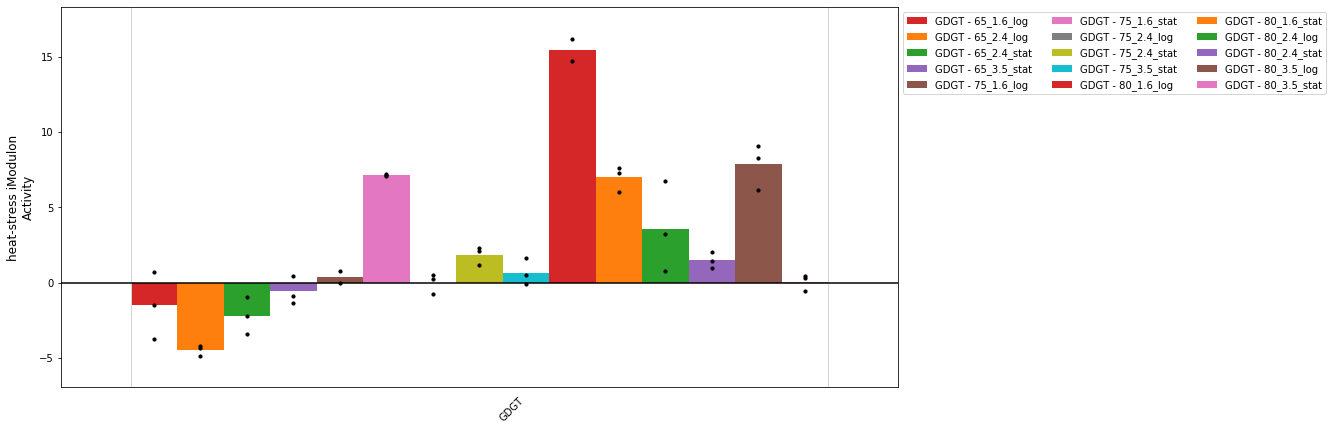

In [76]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 'heat-stress', projects='GDGT', highlight='GDGT', ax=ax)

### iModulon 6: cold-stress iModulon

In [77]:
ica_data.rename_imodulons({6: 'cold-stress'})

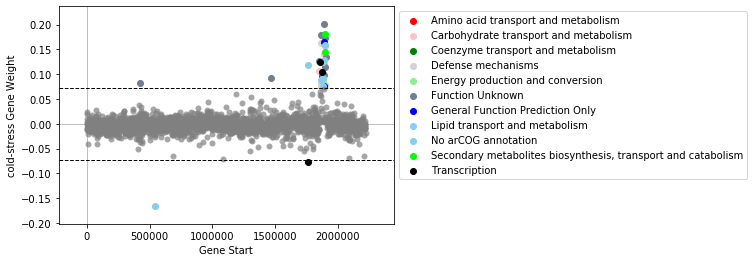

In [78]:
plot_gene_weights(ica_data, 'cold-stress')

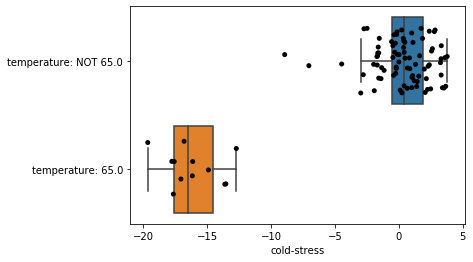

In [79]:
metadata_boxplot(ica_data, 'cold-stress', n_boxes=2)

In [80]:
ica_data.view_imodulon('cold-stress')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS02480,0.082701,Saci_0517,Saci_0517,Sacid_00510,NaN,426068,426739,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U2VVL2,NC_007181.1,Op297,NaN
SACI_RS11570,-0.164900,SACI_RS11570,NaN,NaN,NaN,542365,542577,+,putative integrase,NaN,No arCOG annotation,UPI000AE9D732,NC_007181.1,Op365,NaN
SACI_RS11700,0.092745,Saci_1709,Saci_1709,NaN,NaN,1468477,1468635,-,TRASH domain-containing protein,NaN,Function Unknown,UPI00005526DC,NC_007181.1,Op951,NaN
SACI_RS09400,-0.076305,Saci_1947,Saci_1947,Sacid_01934,NaN,1759516,1759740,+,hypothetical protein,hypothetical protein,Transcription,A0A0U3GMH0,NC_007181.1,Op1150,NaN
SACI_RS11990,0.119218,SACI_RS11990,NaN,NaN,NaN,1760019,1760123,+,type II toxin-antitoxin system VapC family toxin,NaN,No arCOG annotation,UPI0011BDD67A,NC_007181.1,Op1151,NaN
SACI_RS09835,0.106142,glpF,Saci_2034,Sacid_02029,NaN,1849204,1850085,+,aquaporin,Glycerol uptake facilitator protein,Carbohydrate transport and metabolism,A0A0U3FQ15,NC_007181.1,Op1211,NaN
SACI_RS09840,0.127140,Saci_2035,Saci_2035,Sacid_02030,NaN,1850246,1851289,+,DUF917 domain-containing protein,hypothetical protein,Function Unknown,A0A0U2NAZ5,NC_007181.1,Op1212,NaN
SACI_RS09865,0.125052,Saci_2040,Saci_2040,Sacid_02035,NaN,1855837,1856316,-,Lrp/AsnC family transcriptional regulator,hypothetical protein,Transcription,A0A0U3GNH8,NC_007181.1,Op1214,NaN
SACI_RS09895,0.074009,Saci_2046,Saci_2046,Sacid_02041,NaN,1863675,1866395,-,HD domain-containing protein,hypothetical protein,Defense mechanisms,A0A0U2WUV5,NC_007181.1,Op1216,NaN
SACI_RS09900,0.088281,Saci_2047,Saci_2047,Sacid_02042,NaN,1866379,1866594,-,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3GQM3,NC_007181.1,Op1216,NaN


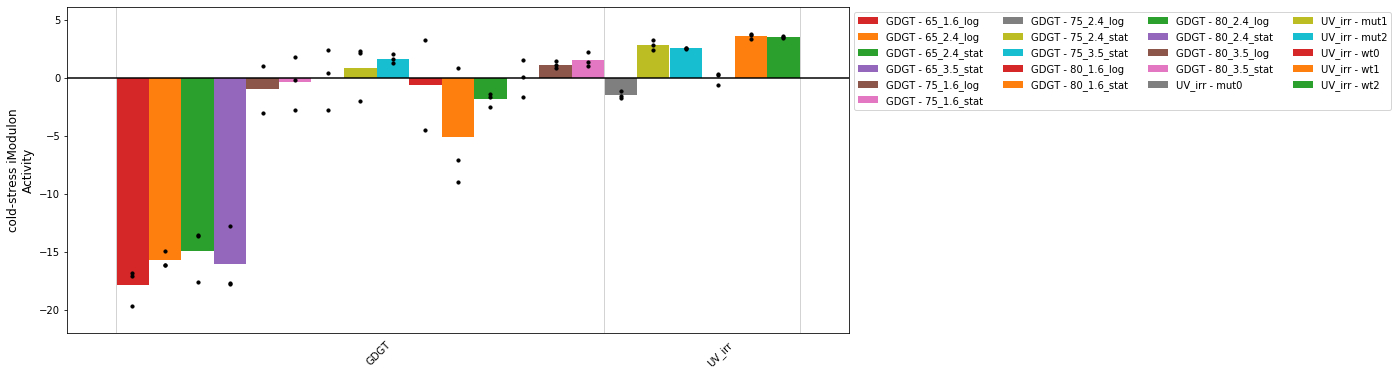

In [81]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'cold-stress', projects=['GDGT', 'UV_irr'], highlight=['GDGT', 'UV_irr'], ax=ax)

### iModulon 15: single_gene_1 (Uncharacterized iModulon)

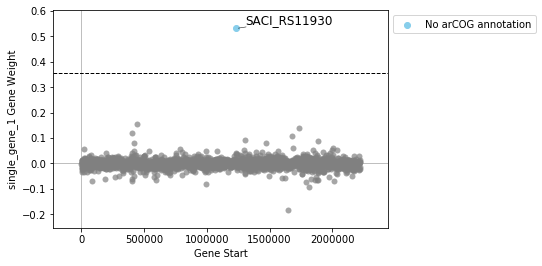

In [82]:
plot_gene_weights(ica_data, 'single_gene_1')

In [83]:
ica_data.view_imodulon('single_gene_1')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS11930,0.530262,SACI_RS11930,NaN,NaN,NaN,1235099,1235239,-,hypothetical protein,NaN,No arCOG annotation,UPI0012D9D522,NC_007181.1,Op799,NaN


### iModulon 16: single_gene_2 (Uncharacterized iModulon)

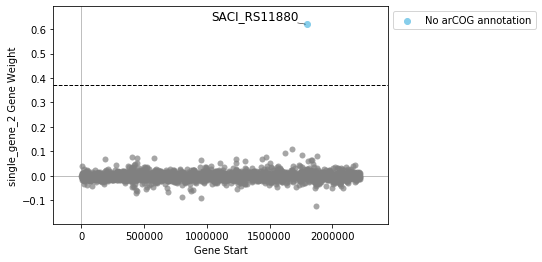

In [84]:
plot_gene_weights(ica_data, 'single_gene_2')

In [85]:
ica_data.view_imodulon('single_gene_2')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS11880,0.61887,SACI_RS11880,NaN,NaN,NaN,1802184,1802258,+,PIN domain nuclease,NaN,No arCOG annotation,NaN,NC_007181.1,Op1179,NaN


### iModulon 20: Pyroglutamate iModulon [E coli ortholog: Nac, Pur-2]

- Putative Nitrogen Starvation / Aromatic degradation / Antibiotic production iModulon

- Operon from Saci_2036 to Saci_2042 (excluding Saci_2040)

- Saci_2040 is a predicted TF [uniprot] and is missing from this operon (potential regulator of this operon?)

- Possible Glutathione iModulon?

    - https://pubmed.ncbi.nlm.nih.gov/29667297/

In [86]:
ica_data.rename_imodulons({20: 'Pyroglutamate'})

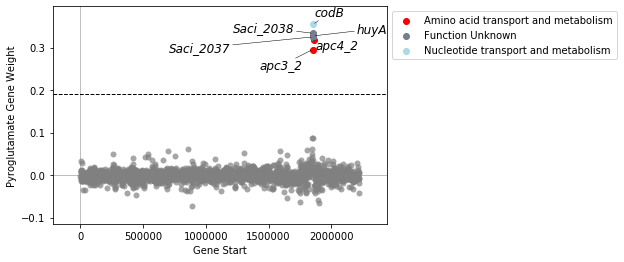

In [87]:
plot_gene_weights(ica_data, 'Pyroglutamate')

In [88]:
ica_data.view_imodulon('Pyroglutamate')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS09845,0.295548,apc3_2,Saci_2036,Sacid_02031,NaN,1851278,1852822,-,hydantoinase subunit beta,Acetophenone carboxylase gamma subunit,Amino acid transport and metabolism,A0A0U3HGC9,NC_007181.1,Op1213,NaN
SACI_RS09850,0.325206,Saci_2037,Saci_2037,Sacid_02032,NaN,1852813,1853889,-,DUF917 domain-containing protein,hypothetical protein,Function Unknown,A0A0U3FHU3,NC_007181.1,Op1213,NaN
SACI_RS09855,0.333669,Saci_2038,Saci_2038,Sacid_02033,NaN,1853894,1854283,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3F9L6,NC_007181.1,Op1213,NaN
SACI_RS09860,0.354428,codB,Saci_2039,Sacid_02034,NaN,1854280,1855647,-,cytosine permease,Cytosine permease,Nucleotide transport and metabolism,A0A0U2NH29,NC_007181.1,Op1213,NaN
SACI_RS09870,0.327592,huyA,Saci_2041,Sacid_02036,apc3_3,1856455,1858497,+,hydantoinase/oxoprolinase family protein,Acetophenone carboxylase gamma subunit,Amino acid transport and metabolism,A0A0U3FQD2,NC_007181.1,Op1215,NaN
SACI_RS09875,0.316897,apc4_2,Saci_2042,Sacid_02037,NaN,1858503,1860227,+,hydantoinase B/oxoprolinase family protein,Acetophenone carboxylase delta subunit,Amino acid transport and metabolism,A0A0U3FHA6,NC_007181.1,Op1215,NaN


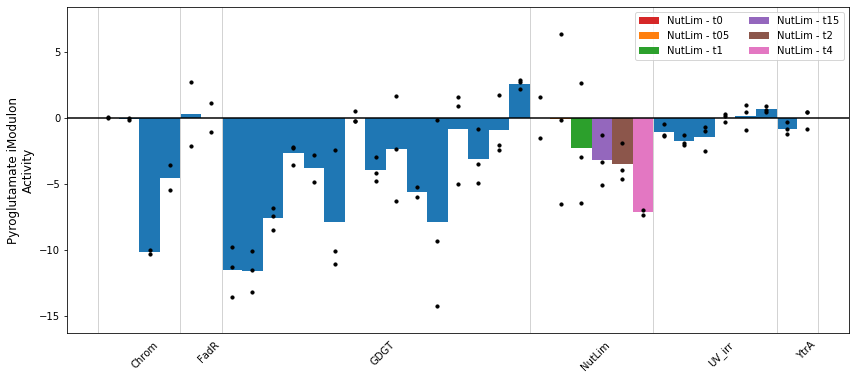

In [89]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Pyroglutamate', highlight=['NutLim'], ax=ax)

### iModulon 28: single_gene_3 (Uncharacterized iModulon)

In [90]:
ica_data.rename_imodulons({'single_gene_4': 'single_gene_3'})

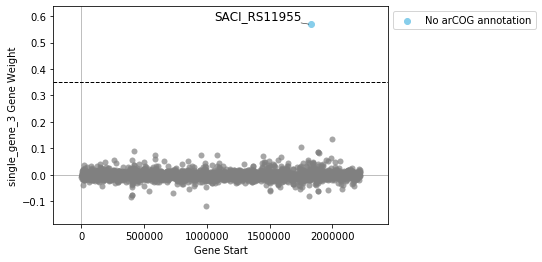

In [91]:
plot_gene_weights(ica_data, 'single_gene_3')

In [92]:
ica_data.view_imodulon('single_gene_3')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS11955,0.568018,SACI_RS11955,NaN,NaN,NaN,1829337,1829474,+,hypothetical protein,NaN,No arCOG annotation,UPI000AA94FC4,NC_007181.1,Op1199,NaN


### iModulon 30: Cytochrome reductase (SoxLABCD) iModulon

In [93]:
ica_data.rename_imodulons({30: 'SoxLABCD'})

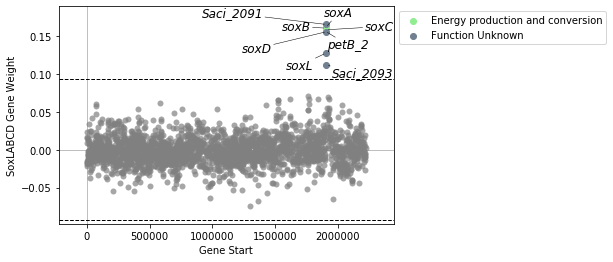

In [94]:
plot_gene_weights(ica_data, 'SoxLABCD')

In [95]:
ica_data.view_imodulon('SoxLABCD')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS11755,0.127410,soxL,Saci_2085,Sacid_02081,NaN,1903637,1903837,-,hypothetical protein,hypothetical protein,Function Unknown,UPI0002B27972,NC_007181.1,Op1243,NaN
SACI_RS10080,0.156381,petB_2,Saci_2087,Sacid_02083,soxC,1903968,1905659,-,cytochrome bc complex cytochrome b subunit,Cytochrome b6,Energy production and conversion,A0A0U3FZ60,NC_007181.1,Op1244,"hypotonic-Na,hypotonic-all,acid-stress,Saci_0264"
SACI_RS10085,0.160649,soxB,Saci_2088,Sacid_02084,NaN,1905649,1907202,-,"quinol oxidase subunit 1, cytochrome b6 SoxB",hypothetical protein,Energy production and conversion,A0A0U3H4H8,NC_007181.1,Op1244,NaN
SACI_RS10090,0.161909,soxA,Saci_2089,Sacid_02085,NaN,1907202,1907708,-,"quinol oxidase subunit 2, quinol oxidase SoxA",hypothetical protein,Energy production and conversion,A0A0U2NHU3,NC_007181.1,Op1244,NaN
SACI_RS10095,0.158420,soxC,Saci_2090,Sacid_02086,soxC_1,1908235,1909221,+,Rieske 2Fe-2S domain-containing protein,hypothetical protein,Energy production and conversion,A0A0U3FPX6,NC_007181.1,Op1245,NaN
SACI_RS10100,0.165432,Saci_2091,Saci_2091,Sacid_02087,NaN,1909218,1909664,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U2NAW8,NC_007181.1,Op1245,NaN
SACI_RS10105,0.155867,soxD,Saci_2092,Sacid_02088,NaN,1909666,1910067,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3HC57,NC_007181.1,Op1245,NaN
SACI_RS10110,0.111692,Saci_2093,Saci_2093,Sacid_02089,NaN,1910243,1910773,+,hypothetical protein,hypothetical protein,Function Unknown,UPI0002B28B76,NC_007181.1,Op1246,NaN


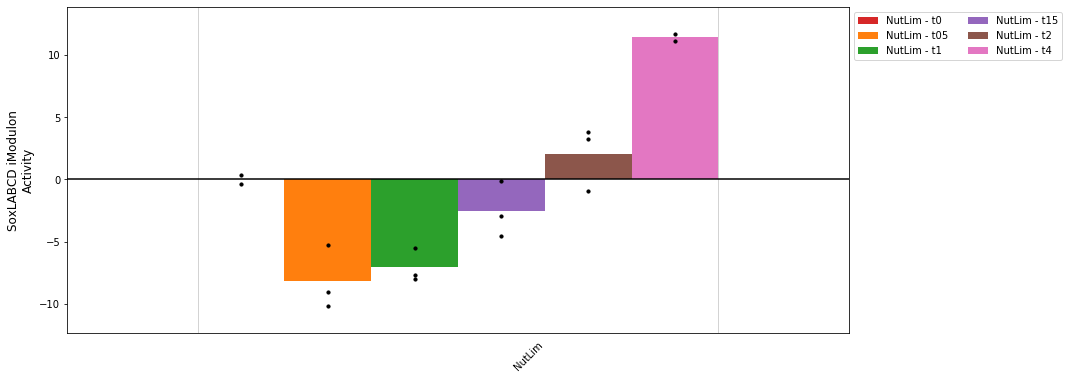

In [96]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'SoxLABCD', projects=['NutLim'], highlight=['NutLim'], ax=ax)

### iModulon 36: NAD(+) biosynthesis iModulon

- Putative Nicotine biosynthesis iModulon
- Putative Pyrmidine degradation iModulon

In [97]:
ica_data.rename_imodulons({36: 'Quinolinate'})

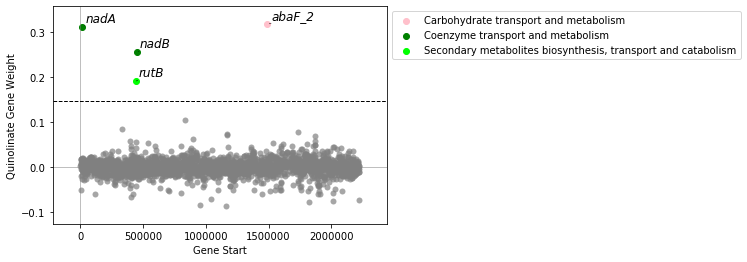

In [98]:
plot_gene_weights(ica_data, 'Quinolinate')

In [99]:
ica_data.view_imodulon('Quinolinate')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS00105,0.311939,nadA,Saci_0023,Sacid_00022,NaN,14685,15683,+,quinolinate synthase NadA,Quinolinate synthase A,Coenzyme transport and metabolism,UPI0000552108,NC_007181.1,Op9,NaN
SACI_RS02590,0.191013,rutB,Saci_0543,Sacid_00533,NaN,443595,444197,-,cysteine hydrolase,Peroxyureidoacrylate/ureidoacrylate amidohydro...,"Secondary metabolites biosynthesis, transport ...",A0A0U2NF55,NC_007181.1,Op311,NaN
SACI_RS02620,0.254860,nadB,Saci_0549,Sacid_00539,NaN,447582,449033,+,NadB (NAD+),L-aspartate oxidase,Coenzyme transport and metabolism,A0A0U3HB63,NC_007181.1,Op314,NaN
SACI_RS08270,0.317011,abaF_2,Saci_1731,Sacid_01695,NaN,1489298,1490629,-,MFS transporter,Fosfomycin resistance protein AbaF,Carbohydrate transport and metabolism,A0A0U2W175,NC_007181.1,Op972,NaN


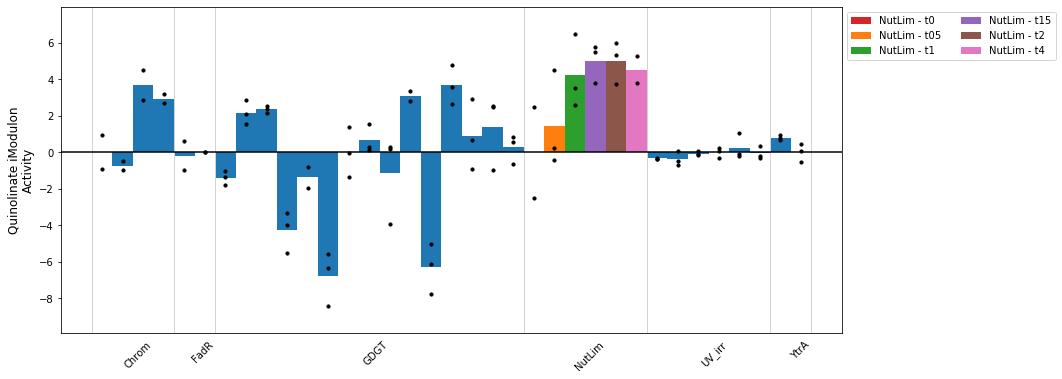

In [100]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Quinolinate', highlight=['NutLim'], ax=ax)

### iModulon 37: Aromatic Compound (degradation) related iModulon (Possibly  Napthalene degradation)

* Contains Saci_2137, a known gene regulated by Saci_2136 (barR)
* Potentially regulated by BarR or BarR-like TF

In [101]:
ica_data.rename_imodulons({37: 'aromatic-degradation'})

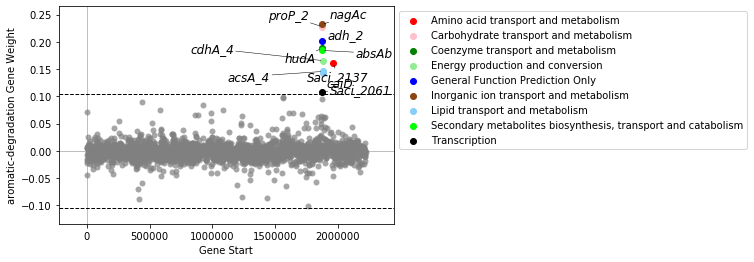

In [102]:
plot_gene_weights(ica_data, 'aromatic-degradation')

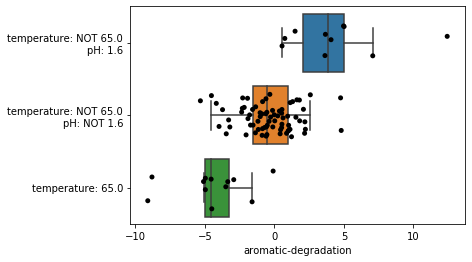

In [103]:
metadata_boxplot(ica_data, 'aromatic-degradation')

In [104]:
ica_data.view_imodulon('aromatic-degradation')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS09935,0.187770,hudA,Saci_2055,Sacid_02050,NaN,1871167,1872585,-,UbiD family decarboxylase,UbiD-like decarboxylase,Coenzyme transport and metabolism,A0A0U3HGB3,NC_007181.1,Op1220,"hypotonic-K,Saci_1955"
SACI_RS09945,0.200823,adh_2,Saci_2057,Sacid_02052,adh,1873919,1874953,-,NAD(P)-dependent alcohol dehydrogenase,Alcohol dehydrogenase,General Function Prediction Only,A0A0U2NH16,NC_007181.1,Op1222,YtrA
SACI_RS09950,0.227832,proP_2,Saci_2058,Sacid_02053,NaN,1875156,1876487,-,MFS transporter,Proline/betaine transporter,Carbohydrate transport and metabolism,A0A0U3GPF6,NC_007181.1,Op1223,NaN
SACI_RS09955,0.231724,nagAc,Saci_2059,Sacid_02054,NaN,1876682,1878025,+,aromatic ring-hydroxylating dioxygenase subuni...,"Naphthalene 1,2-dioxygenase system, large oxyg...",Inorganic ion transport and metabolism,A0A0U3HNQ5,NC_007181.1,Op1224,NaN
SACI_RS09960,0.184133,absAb,Saci_2060,Sacid_02055,NaN,1878019,1878531,+,aromatic ring dioxygenase subunit B,"2-aminobenzenesulfonate 2,3-dioxygenase subuni...","Secondary metabolites biosynthesis, transport ...",A0A0U3FQB8,NC_007181.1,Op1224,NaN
SACI_RS09965,0.108108,Saci_2061,Saci_2061,Sacid_02056,NaN,1878613,1879272,+,helix-turn-helix domain-containing protein,hypothetical protein,Transcription,A0A0U3H5B5,NC_007181.1,Op1225,NaN
SACI_RS09970,0.145584,acsA_4,Saci_2062,Sacid_02057,NaN,1879438,1881123,+,acetyl-CoA synthetase,Acetyl-coenzyme A synthetase,Lipid transport and metabolism,A0A0U3GV35,NC_007181.1,Op1226,biofilm
SACI_RS09975,0.142399,caiD,Saci_2063,Sacid_02058,NaN,1881193,1881957,+,enoyl-CoA hydratase/isomerase family protein,Carnitinyl-CoA dehydratase,Lipid transport and metabolism,A0A0U3GW81,NC_007181.1,Op1227,NaN
SACI_RS09980,0.165472,cdhA_4,Saci_2064,Sacid_02059,NaN,1881960,1884236,+,xanthine dehydrogenase family protein molybdop...,Caffeine dehydrogenase subunit alpha,Energy production and conversion,A0A0U2VXW5,NC_007181.1,Op1227,NaN
SACI_RS10335,0.160738,Saci_2137,Saci_2137,Sacid_02135,spuC,1964516,1965850,+,beta-alanine aminotransferase,Putrescine--pyruvate aminotransferase,Amino acid transport and metabolism,A0A0U3HCW1,NC_007181.1,Op1280,"BarR,hypotonic-K,hypotonic-all"


In [105]:
'+' + '+'.join(ica_data.view_imodulon('aromatic-degradation').old_locus_tag.astype(str))

'+Saci_2055+Saci_2057+Saci_2058+Saci_2059+Saci_2060+Saci_2061+Saci_2062+Saci_2063+Saci_2064+Saci_2137'

### iModulon 40: single_gene_4 (Uncharacterized iModulon)

In [106]:
ica_data.rename_imodulons({'single_gene_5': 'single_gene_4'})

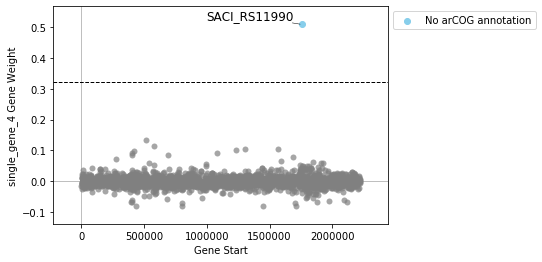

In [107]:
plot_gene_weights(ica_data, 'single_gene_4')

In [108]:
ica_data.view_imodulon('single_gene_4')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS11990,0.508807,SACI_RS11990,NaN,NaN,NaN,1760019,1760123,+,type II toxin-antitoxin system VapC family toxin,NaN,No arCOG annotation,UPI0011BDD67A,NC_007181.1,Op1151,NaN


### iModulon 42: Uncharacterized iModulon 3

### Batch effect / technical noise iModulon

In [109]:
ica_data.rename_imodulons({42: 'unchar-3'})

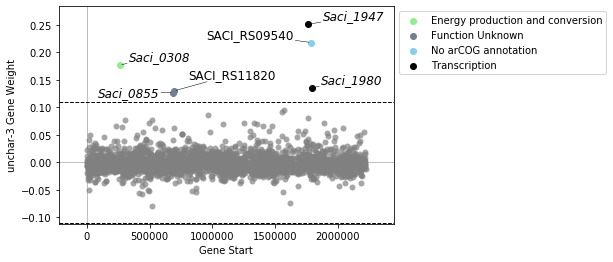

In [110]:
plot_gene_weights(ica_data, 'unchar-3')

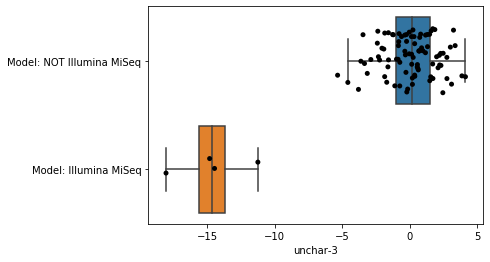

In [111]:
metadata_boxplot(ica_data, 'unchar-3', n_boxes=2)

In [112]:
ica_data.view_imodulon('unchar-3')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01505,0.177318,Saci_0308,Saci_0308,Sacid_00304,NaN,263557,263805,+,biotin attachment protein,hypothetical protein,Energy production and conversion,A0A0U2VW51,NC_007181.1,Op175,NaN
SACI_RS11600,0.126978,Saci_0855,Saci_0855,NaN,NaN,686222,686431,+,TRASH domain-containing protein,NaN,Function Unknown,UPI00005523E6,NC_007181.1,Op447,NaN
SACI_RS11820,0.130100,SACI_RS11820,NaN,NaN,NaN,694196,694357,-,integrase,NaN,Function Unknown,NaN,NC_007181.1,Op455,NaN
SACI_RS09400,0.250978,Saci_1947,Saci_1947,Sacid_01934,NaN,1759516,1759740,+,hypothetical protein,hypothetical protein,Transcription,A0A0U3GMH0,NC_007181.1,Op1150,NaN
SACI_RS09540,0.218173,SACI_RS09540,NaN,Sacid_01963,NaN,1787219,1787317,+,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U2X333,NC_007181.1,Op1168,NaN
SACI_RS09575,0.135677,Saci_1980,Saci_1980,Sacid_01970,NaN,1795356,1795592,+,hypothetical protein,hypothetical protein,Transcription,A0A0U3HCG5,NC_007181.1,Op1174,NaN


### iModulon 43: single_gene_5 (Uncharacterized iModulon)

In [113]:
ica_data.rename_imodulons({'single_gene_6': 'single_gene_5'})

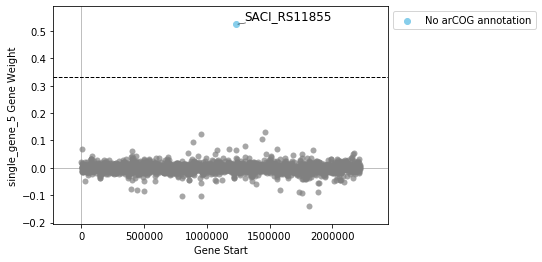

In [114]:
plot_gene_weights(ica_data, 'single_gene_5')

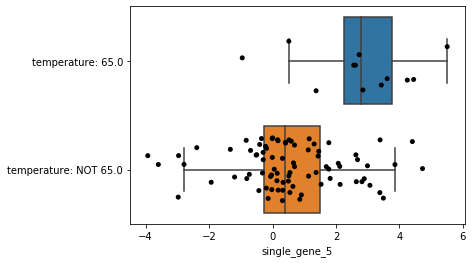

In [115]:
metadata_boxplot(ica_data, 'single_gene_5', n_boxes=2)

In [116]:
ica_data.view_imodulon('single_gene_5')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS11855,0.523488,SACI_RS11855,NaN,NaN,NaN,1231584,1231667,+,putative integrase,NaN,No arCOG annotation,UPI0011BFB8E2,NC_007181.1,Op795,NaN


### iModulon 44: Glycine/Serine iModulon

- Contains 3-phosphoglycerate dehydrogenase, the first committed step to making L-serine from 3-phosphoglycerate
- Contains serine-glyoxylate aminotransferase, which take L-serine and degrades it to produce glycine and 3-hydroxypyruvate
- May have antagonistic relationship to Thiamin iModulon


Additional References:

- https://www.nature.com/articles/s41467-019-11129-5.pdf

In [117]:
ica_data.rename_imodulons({44: 'Gly-Ser-Thr'})

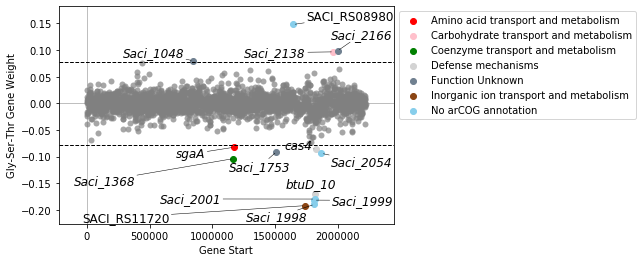

In [118]:
plot_gene_weights(ica_data, 'Gly-Ser-Thr')

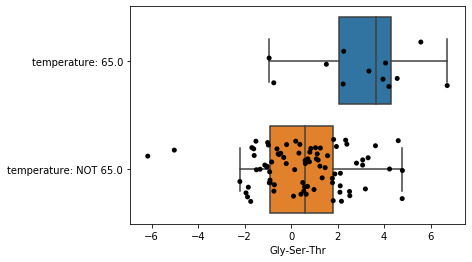

In [119]:
metadata_boxplot(ica_data, 'Gly-Ser-Thr', n_boxes=2)

In [120]:
ica_data.view_imodulon('Gly-Ser-Thr')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS05005,0.079997,Saci_1048,Saci_1048,Sacid_01022,NaN,848599,848853,+,DUF504 domain-containing protein,hypothetical protein,Function Unknown,A0A0U3H296,NC_007181.1,Op552,NaN
SACI_RS06545,-0.103753,Saci_1368,Saci_1368,Sacid_01341,NaN,1168374,1169306,+,3-phosphoglycerate dehydrogenase,Hydroxypyruvate reductase,Coenzyme transport and metabolism,A0A0U2YB16,NC_007181.1,Op759,NaN
SACI_RS06550,-0.082509,sgaA,Saci_1369,Sacid_01342,NaN,1169308,1170423,+,serine-glyoxylate aminotransferase,Soluble hydrogenase 42 kDa subunit,Amino acid transport and metabolism,A0A0U3HJR1,NC_007181.1,Op759,NaN
SACI_RS08380,-0.091023,Saci_1753,Saci_1753,Sacid_01717,NaN,1511477,1511761,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FSN3,NC_007181.1,Op989,NaN
SACI_RS08980,0.148148,SACI_RS08980,NaN,NaN,NaN,1644920,1645132,-,hypothetical protein,NaN,No arCOG annotation,A0A0U3H528,NC_007181.1,Op1085,NaN
SACI_RS11720,-0.192109,SACI_RS11720,NaN,Sacid_01905,NaN,1735450,1735659,-,alkaline phosphatase family protein,hypothetical protein,Inorganic ion transport and metabolism,M1I770,NC_007181.1,Op1129,NaN
SACI_RS09655,-0.189657,Saci_1998,Saci_1998,Sacid_01991,NaN,1813650,1814243,+,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U2YAQ9,NC_007181.1,Op1186,NaN
SACI_RS09660,-0.181669,Saci_1999,Saci_1999,Sacid_01992,NaN,1814254,1815237,+,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3HCF4,NC_007181.1,Op1186,NaN
SACI_RS09665,-0.170774,btuD_10,Saci_2000,Sacid_01993,NaN,1815241,1816053,+,ABC transporter ATP-binding protein,Vitamin B12 import ATP-binding protein BtuD,Defense mechanisms,A0A0U3F9Q2,NC_007181.1,Op1186,NaN
SACI_RS09670,-0.179644,Saci_2001,Saci_2001,Sacid_01994,NaN,1816157,1816741,+,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3FY27,NC_007181.1,Op1187,NaN


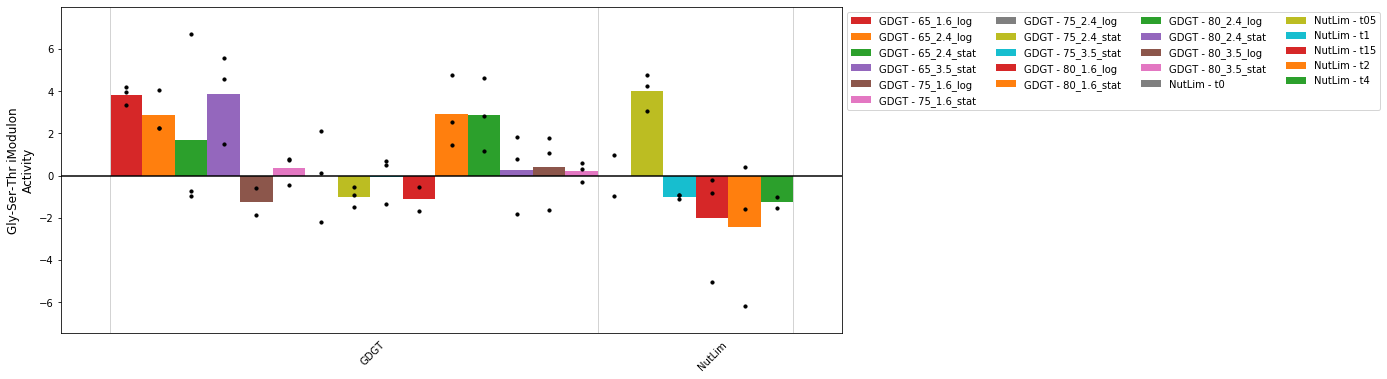

In [121]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Gly-Ser-Thr', projects=['GDGT', 'NutLim'], highlight=['GDGT', 'NutLim'], ax=ax)

---

# Summary Statistics

## Explained Variance by iModulon

In [122]:
exp_var_df = list()

for imod in ica_data.imodulon_names:
    exp_var_dict = dict()
    
    exp_var_dict['name'] = imod
    exp_var_dict['ExpVar'] = explained_variance(ica_data, imodulons=[imod])
    
    exp_var_df.append(exp_var_dict)

exp_var_df = pd.DataFrame(exp_var_df)

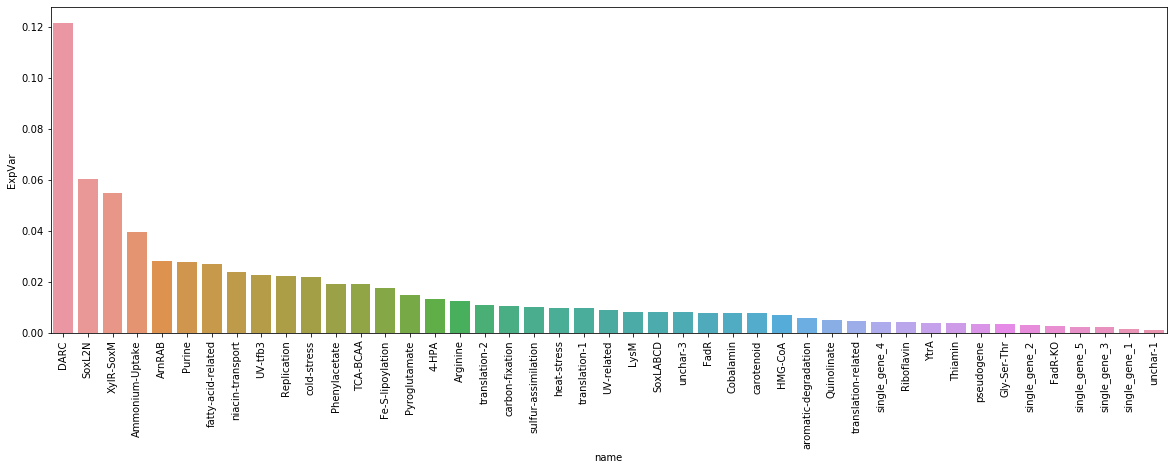

In [123]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.barplot(x='name', y='ExpVar', ax=ax,
            data=exp_var_df.sort_values(by=['ExpVar'], ascending=False))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [124]:
exp_var_df['ExpVar'].sum()

0.7204840333115917

## Gene-Modulon Connectivitiy/Structure

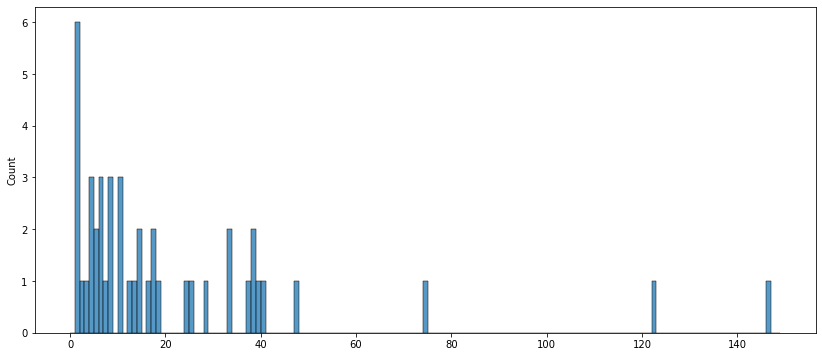

In [125]:
fig, ax = plt.subplots(figsize=(14, 6))

bins = range(0, 150)

sns.histplot(data=ica_data.M_binarized.sum(), bins=bins, ax=ax)
#plt.show()

In [126]:
bin_M_sum = ica_data.M_binarized.sum()
bin_M_sum.values

array([  2.,  38.,   5.,  17.,   6.,   4.,  38.,  17.,  40.,   5.,  13.,
        47.,  37.,  10.,   4.,   1.,   1., 122.,  16.,   8.,   6., 146.,
        12.,  10.,   1.,  24.,   7.,   8.,   1.,  25.,   8.,  18.,  74.,
        33.,  39.,  33.,   4.,  10.,   3.,  28.,   1.,  14.,   6.,   1.,
        14.])

In [127]:
def get_counts(bin_M_sum):
    
    xdata = np.array(range(1, 150))
    
    ydata = list()
    for xval in xdata:
        yval = (bin_M_sum.values == xval).sum()
        ydata.append(yval)
    
    return [xdata, np.array(ydata)]

In [128]:
def powerlaw(x, a, b):
    return a*np.power(x, -b)

In [129]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(f=powerlaw,
                       xdata=get_counts(ica_data.M_binarized.sum())[0],
                       ydata=get_counts(ica_data.M_binarized.sum())[1])

In [130]:
popt # best values of a and b which fit

array([5.43781624, 0.7850837 ])

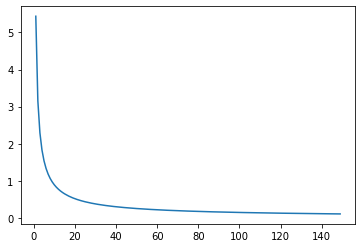

In [131]:
plt.plot(get_counts(bin_M_sum)[0], powerlaw(get_counts(bin_M_sum)[0], popt[0], popt[1]))

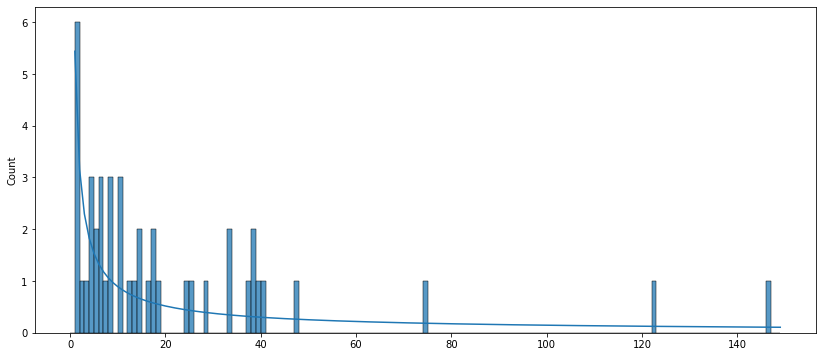

In [132]:
fig, ax = plt.subplots(figsize=(14, 6))

bins = range(0, 150)

sns.histplot(data=ica_data.M_binarized.sum(), bins=bins, ax=ax)
ax.plot(get_counts(bin_M_sum)[0], powerlaw(get_counts(bin_M_sum)[0], popt[0], popt[1]))

plt.savefig('../figures/imodulon_hist.pdf')

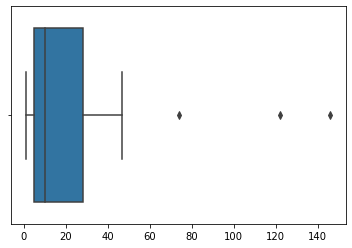

In [133]:
sns.boxplot(x=ica_data.M_binarized.sum())

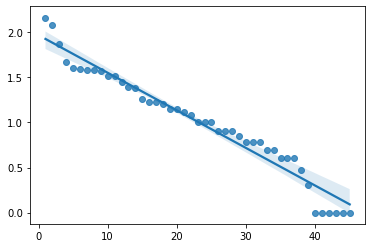

In [134]:
y = np.log10(ica_data.M_binarized.sum().sort_values(ascending=False).values)
x = np.array(range(len(y))) + 1

sns.regplot(x=x, y=y, robust=True)
plt.show()

In [135]:
m, b = np.polyfit(x, y, 1)

print('log10(y) = '+str(m)+' * x + '+str(b))

fitting = np.polyfit(x, y, 1, full=True)
SSE = fitting[1][0]

diff = y - y.mean()
square_diff = diff ** 2
SST = square_diff.sum()

R2 = 1 - SSE/SST 
print('R^2 value: ', R2)

log10(y) = -0.042602538656264254 * x + 1.9854592096867418
R^2 value:  0.9578131993447726


In [136]:
# Total Gene-iModulon relationships
ica_data.M_binarized.sum().sum()

957.0

In [137]:
ica_data.imodulon_table.replace('', np.nan, inplace=True)

In [138]:
known_imods = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
known_imods

,pvalue,regulator,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
XylR-SoxM,3.084629e-11,XylR,0.212766,0.370370,0.270270,10.0,27.0,47.0,1.0,NaN,"GlpR, crp-KO"
YtrA,2.737665e-13,YtrA,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0,NaN,NaN
LysM,6.324328e-09,LysM,0.400000,0.571429,0.470588,4.0,7.0,10.0,1.0,NaN,NaN
UV-tfb3,1.348608e-36,tfb3,0.937500,0.937500,0.937500,15.0,16.0,16.0,1.0,NaN,NaN
ArnRAB,9.674248e-19,ArnR+ArnR1+ArnA+ArnB,0.875000,0.875000,0.875000,7.0,8.0,8.0,4.0,NaN,NaN
FadR,1.349778e-37,FadR,0.760000,0.791667,0.775510,19.0,24.0,25.0,1.0,NaN,FadR/IclR


In [139]:
known_imods.TP.sum() + 1 # add 1 for FadR-KO

65.0

In [140]:
ica_data.view_imodulon('XylR-SoxM')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01445,0.066414,moaA_1,Saci_0296,Sacid_00292,NaN,251845,252864,-,PTO1314 family radical SAM protein,"GTP 3',8-cyclase",General Function Prediction Only,A0A0U3H336,NC_007181.1,Op165,NaN
SACI_RS01495,0.060348,acsA_1,Saci_0306,Sacid_00302,acs,260644,262641,-,acetate--CoA ligase,Acetyl-coenzyme A synthetase,Lipid transport and metabolism,A0A0U3HAP5,NC_007181.1,Op173,NaN
SACI_RS01505,-0.071221,Saci_0308,Saci_0308,Sacid_00304,NaN,263557,263805,+,biotin attachment protein,hypothetical protein,Energy production and conversion,A0A0U2VW51,NC_007181.1,Op175,NaN
SACI_RS01585,-0.093007,Saci_0324,Saci_0324,Sacid_00320,NaN,277460,278311,-,sulfite exporter TauE/SafE family protein,putative membrane transporter protein,General Function Prediction Only,A0A0U2VW32,NC_007181.1,Op186,NaN
SACI_RS01760,0.063850,Saci_0360,Saci_0360,Sacid_00355,NaN,303121,304209,+,hypothetical protein,hypothetical protein,General Function Prediction Only,M1ISI4,NC_007181.1,Op202,NaN
SACI_RS11800,0.111932,SACI_RS11800,NaN,NaN,NaN,442246,442317,-,hypothetical protein,NaN,No arCOG annotation,NaN,NC_007181.1,Op310,NaN
SACI_RS11555,-0.090678,SACI_RS11555,NaN,NaN,NaN,499991,500131,+,putative integrase,NaN,No arCOG annotation,UPI0011BFB8BC,NC_007181.1,Op336,NaN
SACI_RS03215,0.061065,abaF_1,Saci_0675,Sacid_00657,NaN,535612,536928,-,MFS transporter,Fosfomycin resistance protein AbaF,Carbohydrate transport and metabolism,A0A0U3FWX6,NC_007181.1,Op361,NaN
SACI_RS11610,-0.070474,Saci_0873,Saci_0873,Sacid_00851,NaN,700810,700977,-,YHS domain-containing protein,hypothetical protein,Function Unknown,M1ITZ6,NC_007181.1,Op459,NaN
SACI_RS05015,0.061516,parA,Saci_1050,Sacid_01024,NaN,850873,852171,+,"ParA, chromosome-partioning ATPase, AAA family...",hypothetical protein,"Cell cycle control, cell division, chromosome ...",A0A0U2W2Y0,NC_007181.1,Op554,BarR


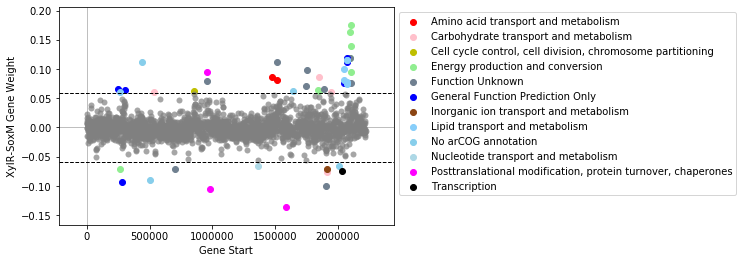

In [141]:
plot_gene_weights(ica_data, 'XylR-SoxM')

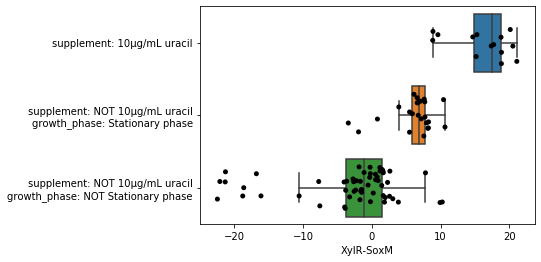

In [142]:
metadata_boxplot(ica_data, 'XylR-SoxM')

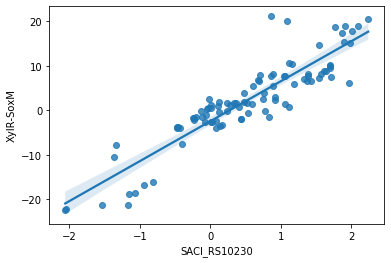

In [143]:
xylR_expr = ica_data.X.loc['SACI_RS10230'] #xylR expression

sns.regplot(x=xylR_expr, y=ica_data.A.loc['XylR-SoxM'])

plt.savefig('../figures/xylR_scatter.pdf')

In [144]:
# Get Pearson R

from scipy.stats import pearsonr

pearsonr(xylR_expr, ica_data.A.loc['XylR-SoxM'])

(0.9062255092438731, 1.5429377785134534e-36)

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [145]:
save_to_json(ica_data,'../data/saci_ica_data.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [146]:
ica_data.imodulon_table.to_csv('../data/iModulon_table.csv')

# Examine global activity correlations

Mutual information can find more biologically relevant clusters than other correlation methods, so this is recommended. This identifies both linear correlations and non-linear correlations.

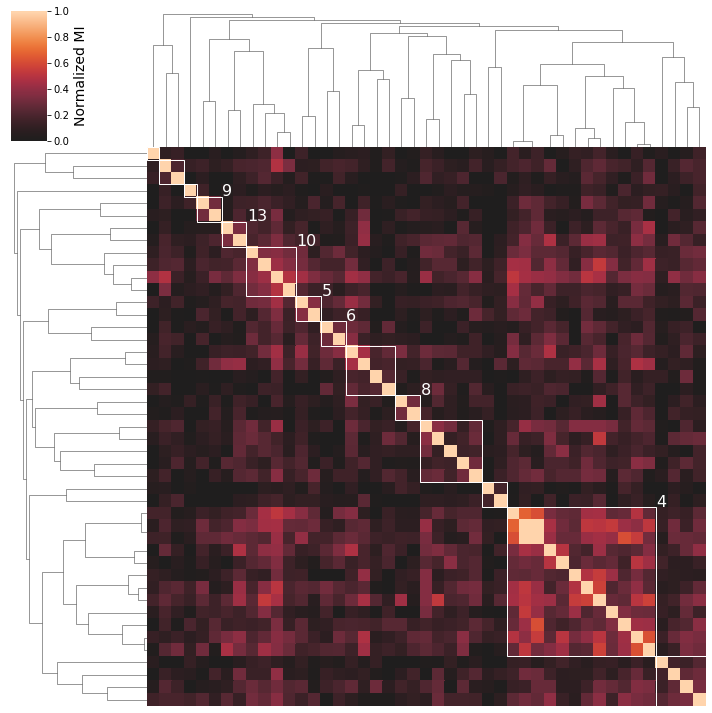

[AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                         distance_threshold=0.9750000000000001,
                         linkage='complete', n_clusters=None)]

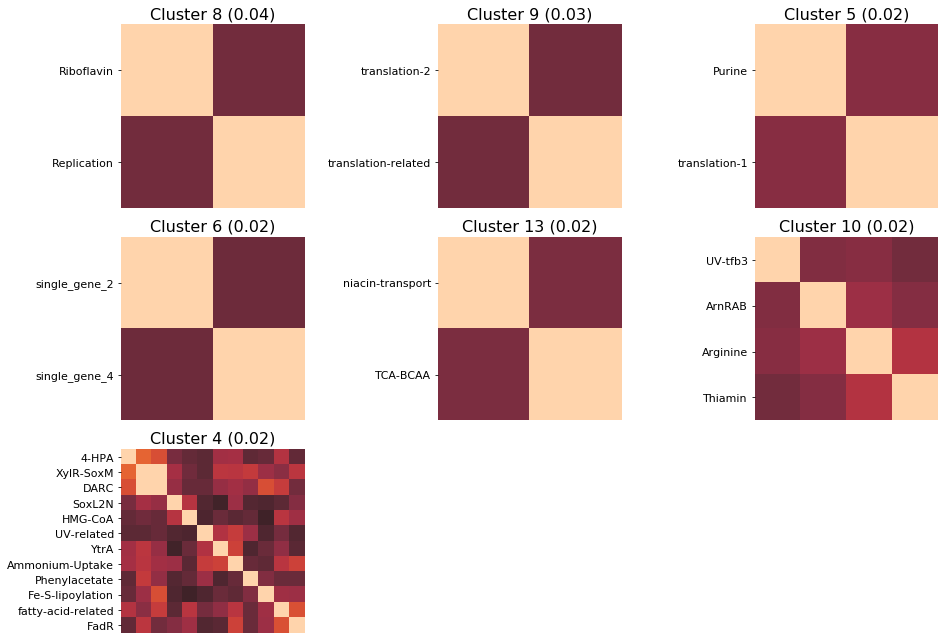

In [147]:
cluster_activities(ica_data,correlation_method='mutual_info',show_best_clusters=True)

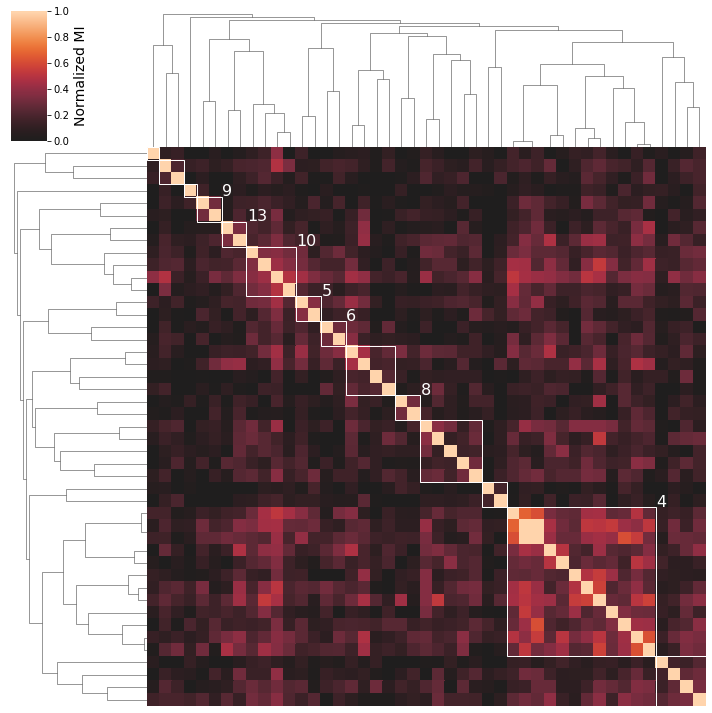

list

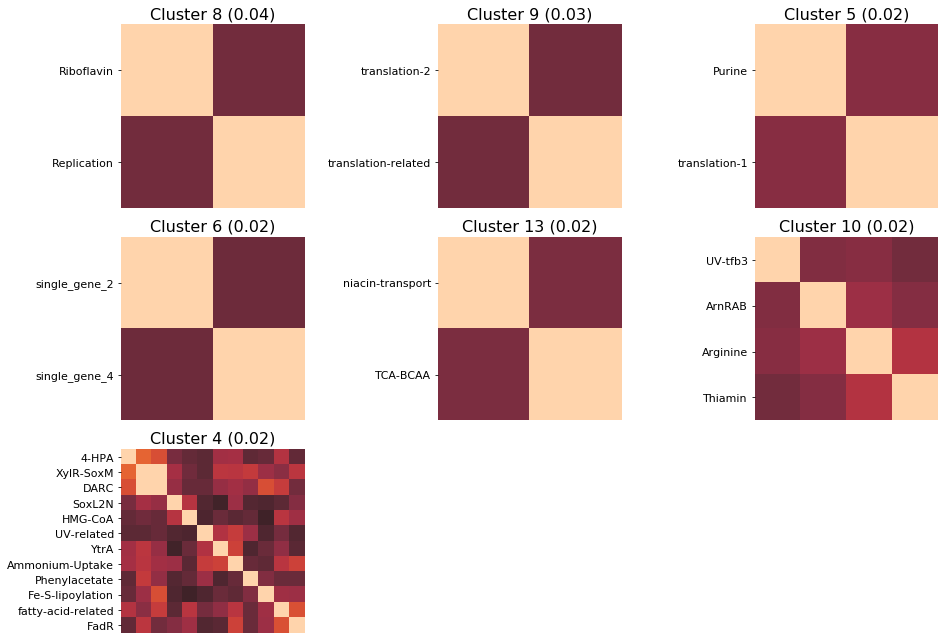

In [148]:
type(cluster_activities(ica_data,correlation_method='mutual_info',show_best_clusters=True))

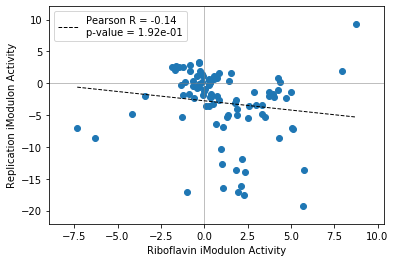

In [149]:
compare_activities(ica_data, 'Riboflavin', 'Replication')

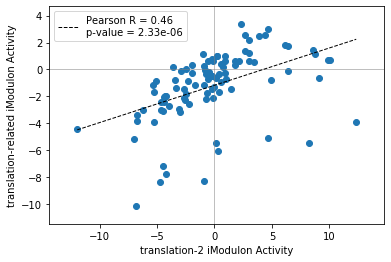

In [150]:
compare_activities(ica_data, 'translation-2', 'translation-related')

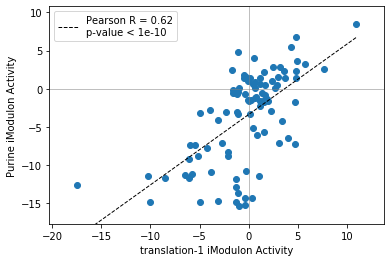

In [151]:
compare_activities(ica_data, 'translation-1', 'Purine')

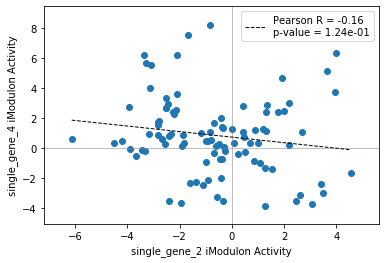

In [152]:
compare_activities(ica_data, 'single_gene_2', 'single_gene_4')

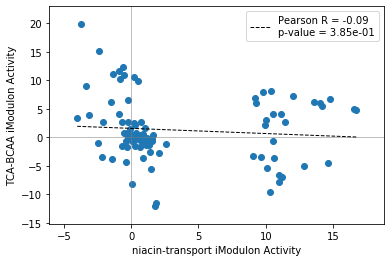

In [153]:
compare_activities(ica_data, 'niacin-transport', 'TCA-BCAA')

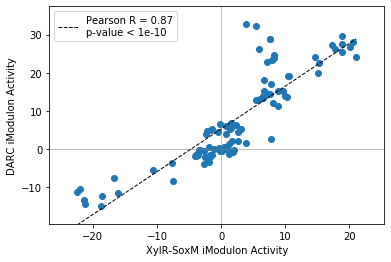

In [154]:
# Could DARC be the second pentose-related iModulon?
compare_activities(ica_data, 'XylR-SoxM', 'DARC')

# Random Testing

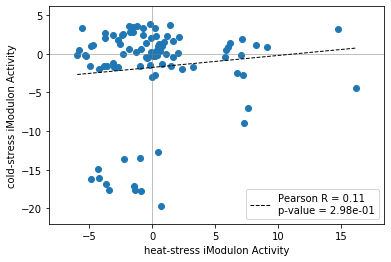

In [155]:
compare_activities(ica_data, 'heat-stress', 'cold-stress')

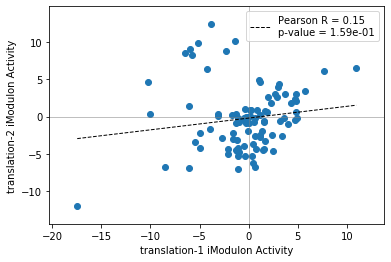

In [156]:
compare_activities(ica_data, 'translation-1', 'translation-2')

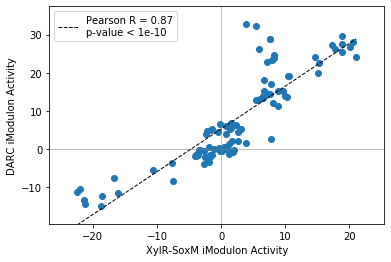

In [157]:
compare_activities(ica_data, 'XylR-SoxM', 'DARC')

In [158]:
from matplotlib_venn import venn3

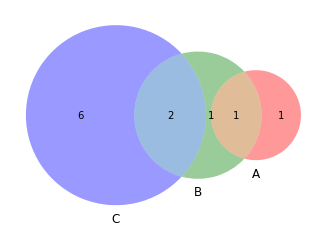

In [159]:
v = venn3(subsets=[set([1,2]), set([2,3,4,5]), set([4,5,6,7,8,9,10,11])])

In [160]:
XylR_SoxM = set(ica_data.view_imodulon('XylR-SoxM').index)

XylR = set(ica_data.trn.loc[ica_data.trn.regulator=='XylR'].gene_id.values)

SoxM = set(['SACI_RS10920', 'SACI_RS10925', 'SACI_RS10930', 'SACI_RS10935', 'SACI_RS10940', 'SACI_RS10945'])

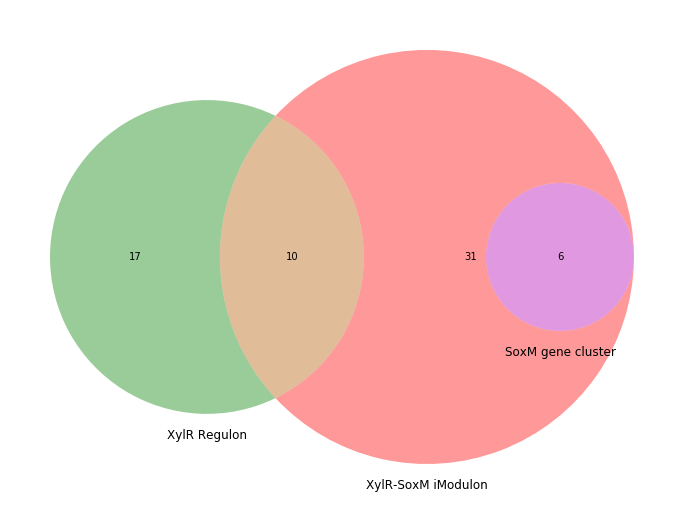

In [161]:
fig, ax = plt.subplots(figsize=(12, 12))

venn3(
    subsets=[XylR_SoxM, XylR, SoxM],
    set_labels=('XylR-SoxM iModulon', 'XylR Regulon', 'SoxM gene cluster'),
    ax=ax
)

plt.savefig('../figures/XylR_venn.pdf')

In [162]:
save_to_json(ica_data,'../data/saci_ica_data.json')

In [163]:
ica_data.imodulon_table

,pvalue,regulator,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
pseudogene,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
heat-stress,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
SoxL2N,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,OxyR
fatty-acid-related,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
Riboflavin,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
niacin-transport,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
cold-stress,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
carbon-fixation,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
Fe-S-lipoylation,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
HMG-CoA,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,


In [164]:
ica_data.gene_table

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS00005,cdc6-3,Saci_0001,,,101,1261,+,ORC1-type DNA replication protein 3 (AAA famil...,,"Replication, recombination and repair",A0A0U3H3T6,NC_007181.1,Op0,
SACI_RS00010,Saci_0002,Saci_0002,Sacid_00002,,1294,1629,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FP71,NC_007181.1,Op0,
SACI_RS00015,Saci_0003,Saci_0003,Sacid_00003,,1665,2504,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U2NAH6,NC_007181.1,Op0,
SACI_RS00020,Saci_0004,Saci_0004,Sacid_00004,,2553,3056,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3HCE5,NC_007181.1,Op1,
SACI_RS00025,Saci_0005,Saci_0005,Sacid_00005,,3049,3768,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FGW8,NC_007181.1,Op1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SACI_RS11465,COQ5_5,Saci_2371,Sacid_02369,,2218618,2219355,-,class I SAM-dependent methyltransferase,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...","Secondary metabolites biosynthesis, transport ...",A0A0U2NGD2,NC_007181.1,Op1444,
SACI_RS11470,Saci_2372,Saci_2372,Sacid_02370,,2219468,2220394,+,ornithine cyclodeaminase family protein,Delta(1)-pyrroline-2-carboxylate reductase,Amino acid transport and metabolism,A0A0U2Y205,NC_007181.1,Op1445,
SACI_RS11475,cobO,Saci_2373,Sacid_02371,,2220381,2220989,-,"cob(I)yrinic acid a,c-diamide adenosyltransferase",Cobalamin adenosyltransferase,Coenzyme transport and metabolism,UPI000055294E,NC_007181.1,Op1446,
SACI_RS11480,Saci_2374,Saci_2374,Sacid_02372,,2221039,2224263,-,S8 family serine peptidase,hypothetical protein,"Posttranslational modification, protein turnov...",A0A0U3FPL4,NC_007181.1,Op1447,
